In [1]:
import torch
import torch.nn as nn
from libs.models import encoder3,encoder4
from libs.models import decoder3,decoder4
import numpy as np
from libs.Matrix import MulLayer
from libs.Criterion import LossCriterion
from sklearn.decomposition import PCA


class LossCriterion(nn.Module):
    def __init__(self, style_layers, content_layers, style_weight, content_weight):
        super(LossCriterion, self).__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.style_weight = style_weight
        self.content_weight = content_weight
        self.styleLosses = [styleLoss()] * len(style_layers)
        self.contentLosses = [nn.MSELoss()] * len(content_layers)

    def forward(self, tF, sF, cF):
        # Content loss
        totalContentLoss = 0
        for i, layer in enumerate(self.content_layers):
            cf_i = cF[layer].detach()
            tf_i = tF[layer]
            loss_i = self.contentLosses[i]
            totalContentLoss += loss_i(tf_i, cf_i)
        totalContentLoss = totalContentLoss * self.content_weight

        # Style loss
        
        totalStyleLoss = 0
        for i, layer in enumerate(self.style_layers):
            sf_i = sF[layer].detach()
            tf_i = tF[layer]
            loss_i = self.styleLosses[i]
            totalStyleLoss += loss_i(tf_i, sf_i)
        totalStyleLoss = totalStyleLoss * self.style_weight

        loss = totalStyleLoss + totalContentLoss
        return loss, totalStyleLoss, totalContentLoss


class styleLoss(nn.Module):
    def forward(self,input,target):
        ib,ic,ih,iw = input.size()
        iF = input.view(ib,ic,-1)
        iMean = torch.mean(iF,dim=2)
        iCov = GramMatrix()(input)

        tb,tc,th,tw = target.size()
        tF = target.view(tb,tc,-1)
        tMean = torch.mean(tF,dim=2)
        tCov = GramMatrix()(target)

        loss = nn.MSELoss(size_average=False)(iMean,tMean) + nn.MSELoss(size_average=False)(iCov,tCov)
        return loss/tb

class GramMatrix(nn.Module):
    def forward(self,input):
        b, c, h, w = input.size()
        f = input.view(b,c,h*w) # bxcx(hxw)
        # torch.bmm(batch1, batch2, out=None)   #
        # batch1: bxmxp, batch2: bxpxn -> bxmxn #
        G = torch.bmm(f,f.transpose(1,2)) # f: bxcx(hxw), f.transpose: bx(hxw)xc -> bxcxc
        return G.div_(c*h*w)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from libs.Loader import Dataset
from libs.models import encoder4, decoder4
from libs.Criterion import LossCriterion



class Loss_sensitivity:
    def __init__(self, vgg, dec, matrix, style_layers, content_layers, style_weight, content_weight, device):
        self.vgg = vgg.to(device)
        self.dec = dec.to(device)
        self.matrix = matrix.to(device)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.criterion = LossCriterion(style_layers, content_layers, style_weight, content_weight)
        self.device = device

    def add_noise(self, matrix, sigma):
        noise = torch.randn_like(matrix) * sigma
        return matrix + noise

    def forward(self, contentV, styleV):
        with torch.no_grad():
            sF = self.vgg(styleV)
            cF = self.vgg(contentV)
        return sF, cF

    def run_experiment(self, contentV, styleV, sigmas):
        sigma_values = []
        loss_values = []

        sF, cF = self.forward(contentV, styleV)

        for sigma in sigmas:
            
            transformed_features, transmatrix = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
            
            # Add noise to the transformation matrix
            noisy_transmatrix = self.add_noise(transmatrix, sigma)
            
            # Apply the noisy transformation matrix
            b, c, h, w = transformed_features.size()
            compressed_features = self.matrix.compress(transformed_features)
            noisy_transfeature = torch.bmm(noisy_transmatrix, compressed_features.view(b, self.matrix.matrixSize, -1))
            noisy_transfeature = noisy_transfeature.view(b, self.matrix.matrixSize, h, w)
            noisy_transfeature = self.matrix.unzip(noisy_transfeature)
            
            noisy_transfer = self.dec(noisy_transfeature).clamp(0, 1)

            tF = self.vgg(noisy_transfer)
            total_loss, _, _ = self.criterion(tF, sF, cF)

            sigma_values.append(sigma)
            loss_values.append(total_loss.item())
            print(f"Sigma: {sigma}, Total Loss: {total_loss.item()}")

        return sigma_values, loss_values
    
    def run_scaling_vector_experiment(self, contentV, styleV, scale_factors, vector_magnitudes):
        scale_values = []
        vector_values = []
        loss_values = []

        sF, cF = self.forward(contentV, styleV)

        # Get the original transformation matrix
        _, transmatrix = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])

        for scale in scale_factors:
            for vector_mag in vector_magnitudes:
                # Scale the transformation matrix
                scaled_matrix = transmatrix * scale

                # Create a simple vector and add it to each row of the matrix
                vector = torch.ones_like(scaled_matrix[0, 0]) * vector_mag
                modified_matrix = scaled_matrix + vector.unsqueeze(1)

                # Apply the modified transformation
                b, c, h, w = cF[self.style_layers[0]].size()
                compressed_features = self.matrix.compress(cF[self.style_layers[0]])
                modified_features = torch.bmm(modified_matrix, compressed_features.view(b, self.matrix.matrixSize, -1))
                modified_features = modified_features.view(b, self.matrix.matrixSize, h, w)
                modified_features = self.matrix.unzip(modified_features)

                modified_transfer = self.dec(modified_features).clamp(0, 1)

                tF = self.vgg(modified_transfer)
                total_loss, _, _ = self.criterion(tF, sF, cF)

                scale_values.append(scale)
                vector_values.append(vector_mag)
                loss_values.append(total_loss.item())
                print(f"Scale: {scale}, Vector Magnitude: {vector_mag}, Total Loss: {total_loss.item()}")

        return scale_values, vector_values, loss_values
    
    def run_dimension_dropping_experiment(self, contentV, styleV):
        sF, cF = self.forward(contentV, styleV)
        
        # Get the original features
        content_features = cF[self.style_layers[0]]
        style_features = sF[self.style_layers[0]]
        
        b, c, h, w = content_features.size()
        
        content_loss_impacts = []
        style_loss_impacts = []
        
        # Calculate baseline loss
        _, transmatrix = self.matrix(content_features, style_features)
        compressed_features = self.matrix.compress(content_features)
        modified_features = torch.bmm(transmatrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        modified_features = modified_features.view(b, self.matrix.matrixSize, h, w)
        modified_features = self.matrix.unzip(modified_features)
        stylized_image = self.dec(modified_features).clamp(0, 1)
        tF = self.vgg(stylized_image)
        baseline_loss, _, _ = self.criterion(tF, sF, cF)
        
        # Analyze content dimensions
        for dim in range(c):
            dropped_content = content_features.clone()
            dropped_content[:, dim, :, :] = 0
            
            # Apply the transformation
            _, transmatrix = self.matrix(dropped_content, style_features)
            compressed_features = self.matrix.compress(dropped_content)
            modified_features = torch.bmm(transmatrix, compressed_features.view(b, self.matrix.matrixSize, -1))
            modified_features = modified_features.view(b, self.matrix.matrixSize, h, w)
            modified_features = self.matrix.unzip(modified_features)
            
            # Generate the stylized image and calculate loss
            stylized_image = self.dec(modified_features).clamp(0, 1)
            tF = self.vgg(stylized_image)
            total_loss, _, _ = self.criterion(tF, sF, cF)
            
            content_loss_impacts.append(total_loss.item() - baseline_loss.item())
        
        # Analyze style dimensions
        for dim in range(c):
            dropped_style = style_features.clone()
            dropped_style[:, dim, :, :] = 0
            
            # Apply the transformation
            _, transmatrix = self.matrix(content_features, dropped_style)
            compressed_features = self.matrix.compress(content_features)
            modified_features = torch.bmm(transmatrix, compressed_features.view(b, self.matrix.matrixSize, -1))
            modified_features = modified_features.view(b, self.matrix.matrixSize, h, w)
            modified_features = self.matrix.unzip(modified_features)
            
            # Generate the stylized image and calculate loss
            stylized_image = self.dec(modified_features).clamp(0, 1)
            tF = self.vgg(stylized_image)
            total_loss, _, _ = self.criterion(tF, sF, cF)
            
            style_loss_impacts.append(total_loss.item() - baseline_loss.item())
        
        return content_loss_impacts, style_loss_impacts
    
    def run_pca_experiment(self, contentV, styleV, n_components=50):
        sF, cF = self.forward(contentV, styleV)
        
        # Get the original features
        content_features = cF[self.style_layers[0]]
        style_features = sF[self.style_layers[0]]
        
        b, c, h, w = content_features.size()
        
        # Reshape features for PCA
        content_features_flat = content_features.view(b, c, -1).permute(0, 2, 1).reshape(-1, c)
        style_features_flat = style_features.view(b, c, -1).permute(0, 2, 1).reshape(-1, c)
        
        # Apply PCA
        content_pca = PCA(n_components=n_components)
        style_pca = PCA(n_components=n_components)
        
        content_pca.fit(content_features_flat.cpu().numpy())
        style_pca.fit(style_features_flat.cpu().numpy())
        
        # Calculate baseline loss
        _, transmatrix = self.matrix(content_features, style_features)
        compressed_features = self.matrix.compress(content_features)
        modified_features = torch.bmm(transmatrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        modified_features = modified_features.view(b, self.matrix.matrixSize, h, w)
        modified_features = self.matrix.unzip(modified_features)
        stylized_image = self.dec(modified_features).clamp(0, 1)
        tF = self.vgg(stylized_image)
        baseline_loss, _, _ = self.criterion(tF, sF, cF)
        
        content_pca_loss_impacts = []
        style_pca_loss_impacts = []
        
        # Analyze PCA components for content
        for i in range(n_components):
            pca_component = torch.from_numpy(content_pca.components_[i]).float().to(self.device)
            content_flat = content_features.view(b, c, -1)
            projection = torch.matmul(content_flat.permute(0, 2, 1), pca_component.unsqueeze(1)).permute(0, 2, 1)
            dropped_content_flat = content_flat - projection * pca_component.unsqueeze(0).unsqueeze(-1)
            dropped_content = dropped_content_flat.view(b, c, h, w)
            
            # Apply the transformation
            _, transmatrix = self.matrix(dropped_content, style_features)
            compressed_features = self.matrix.compress(dropped_content)
            modified_features = torch.bmm(transmatrix, compressed_features.view(b, self.matrix.matrixSize, -1))
            modified_features = modified_features.view(b, self.matrix.matrixSize, h, w)
            modified_features = self.matrix.unzip(modified_features)
            
            # Generate the stylized image and calculate loss
            stylized_image = self.dec(modified_features).clamp(0, 1)
            tF = self.vgg(stylized_image)
            total_loss, _, _ = self.criterion(tF, sF, cF)
            
            content_pca_loss_impacts.append(total_loss.item() - baseline_loss.item())
        
        # Analyze PCA components for style (similar changes as content)
        for i in range(n_components):
            pca_component = torch.from_numpy(style_pca.components_[i]).float().to(self.device)
            style_flat = style_features.view(b, c, -1)
            projection = torch.matmul(style_flat.permute(0, 2, 1), pca_component.unsqueeze(1)).permute(0, 2, 1)
            dropped_style_flat = style_flat - projection * pca_component.unsqueeze(0).unsqueeze(-1)
            dropped_style = dropped_style_flat.view(b, c, h, w)
            
            # Apply the transformation
            _, transmatrix = self.matrix(content_features, dropped_style)
            compressed_features = self.matrix.compress(content_features)
            modified_features = torch.bmm(transmatrix, compressed_features.view(b, self.matrix.matrixSize, -1))
            modified_features = modified_features.view(b, self.matrix.matrixSize, h, w)
            modified_features = self.matrix.unzip(modified_features)
            
            # Generate the stylized image and calculate loss
            stylized_image = self.dec(modified_features).clamp(0, 1)
            tF = self.vgg(stylized_image)
            total_loss, _, _ = self.criterion(tF, sF, cF)
            
            style_pca_loss_impacts.append(total_loss.item() - baseline_loss.item())
        
        return content_pca_loss_impacts, style_pca_loss_impacts, content_pca, style_pca

/tmp/ipykernel_27323/3236679623.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load('models/vgg_r41.pth', map_location=device))
/tmp/ipykerne

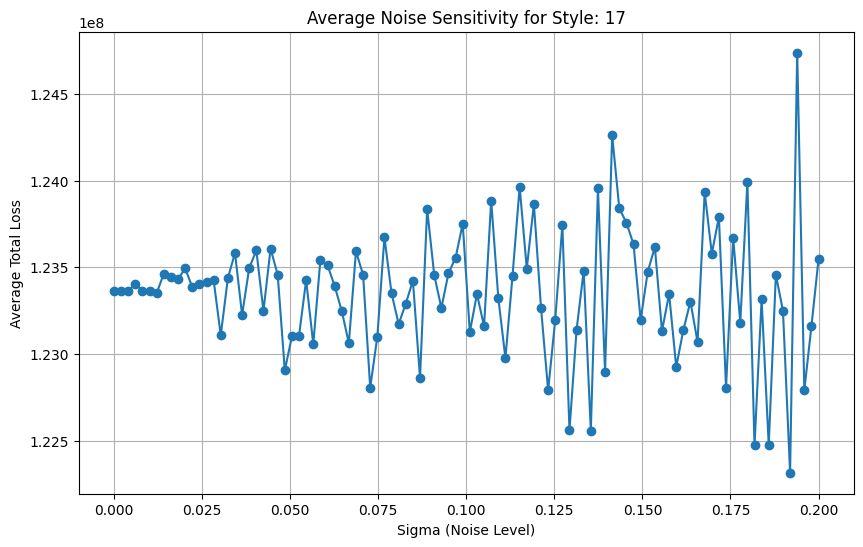

Processing 03: 100%|██████████| 16/16 [00:19<00:00,  1.19s/it]


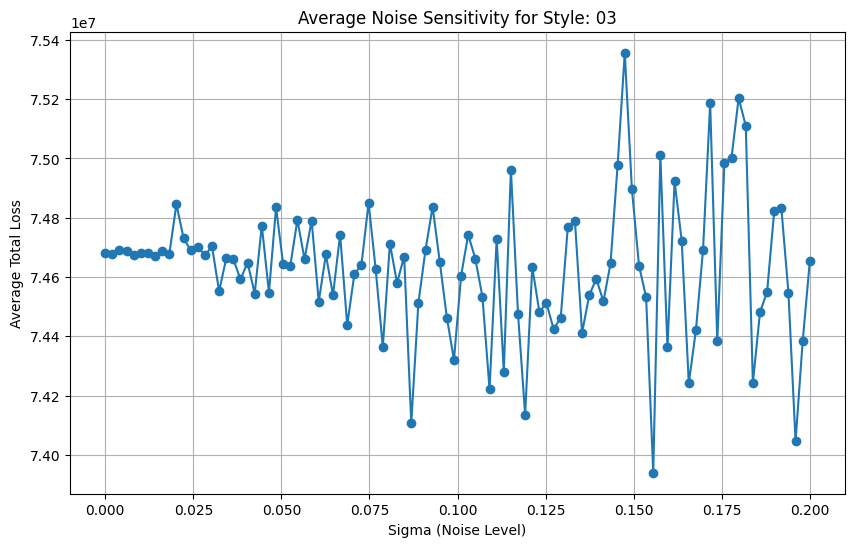

Processing 10: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it]


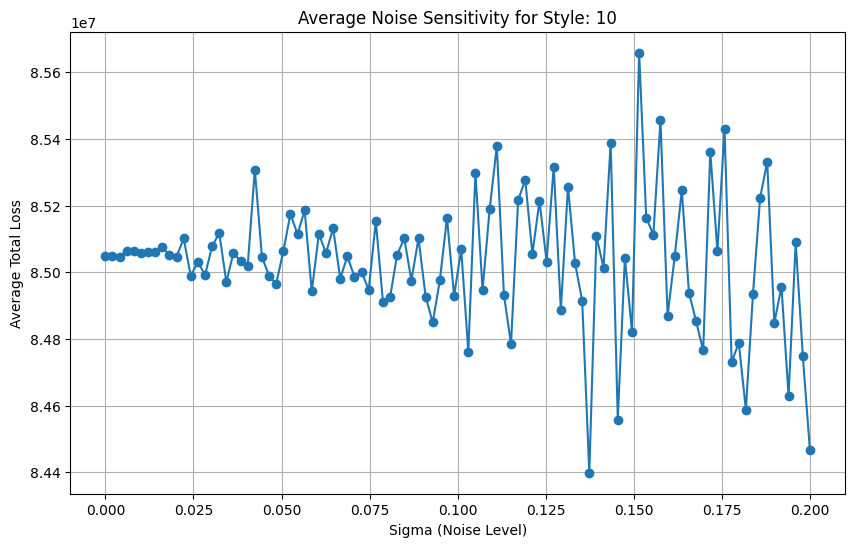

Processing 11: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


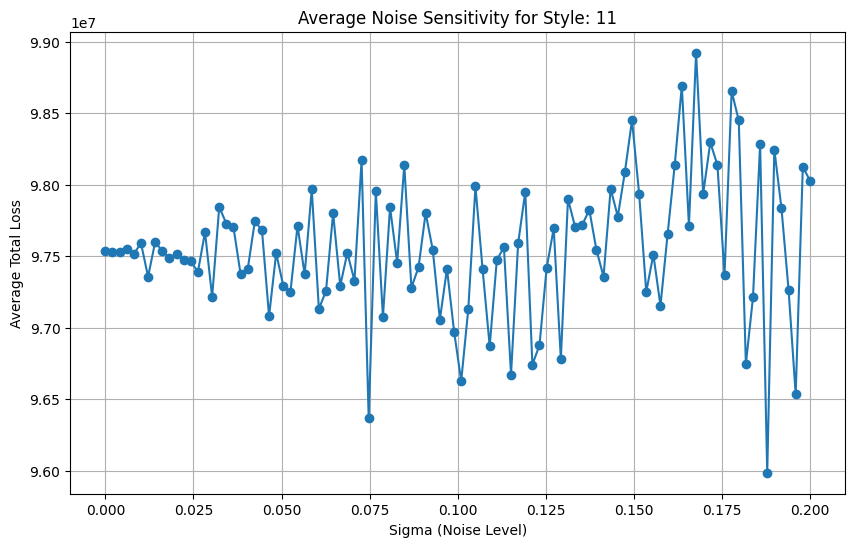

Processing 01: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


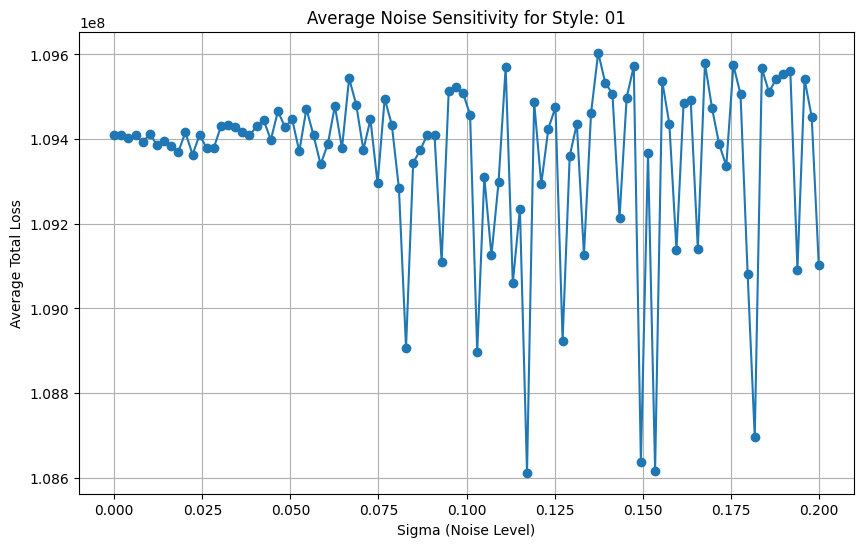

Processing 16: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


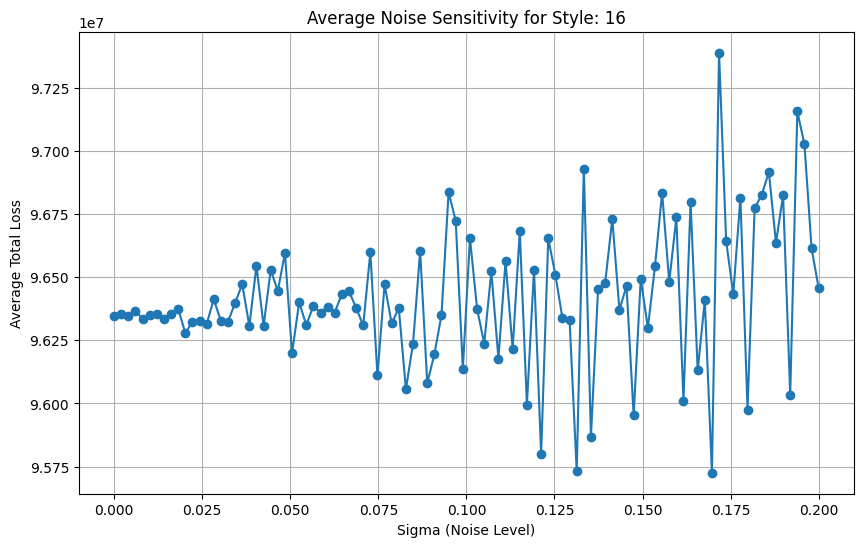

Processing 05: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


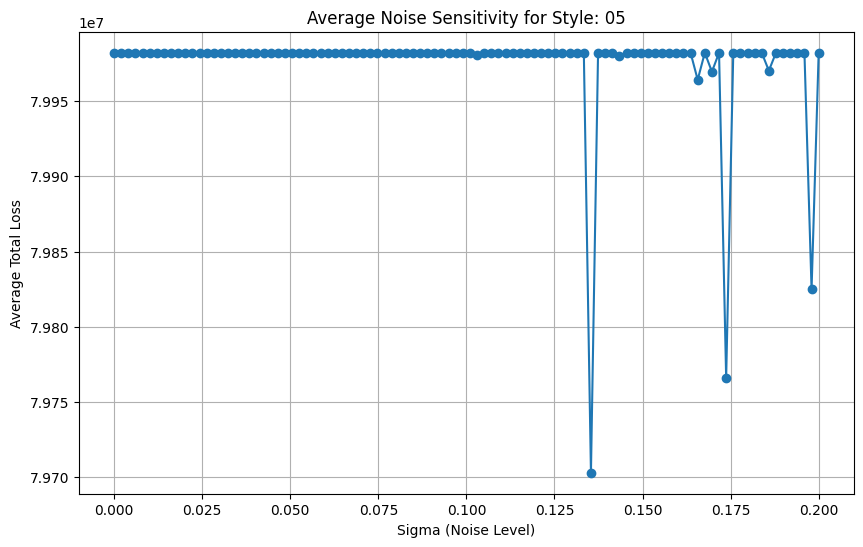

Processing 02: 100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


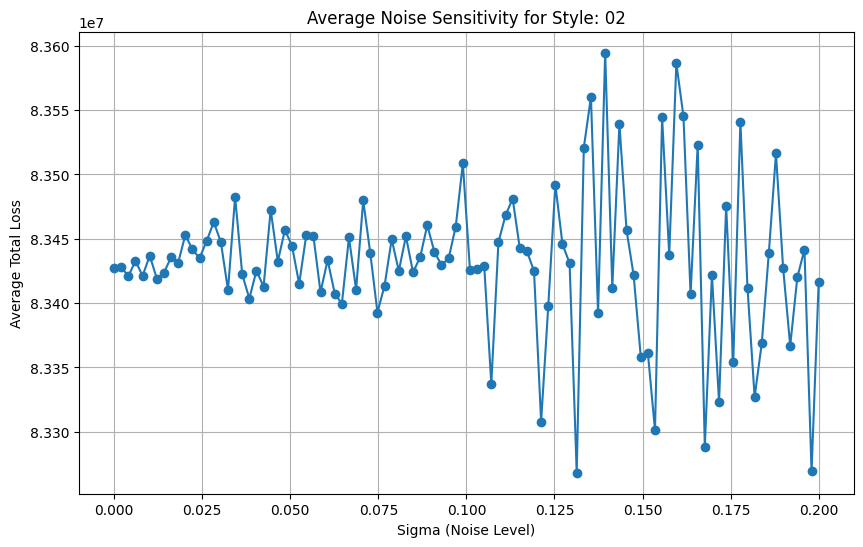

Processing 06: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


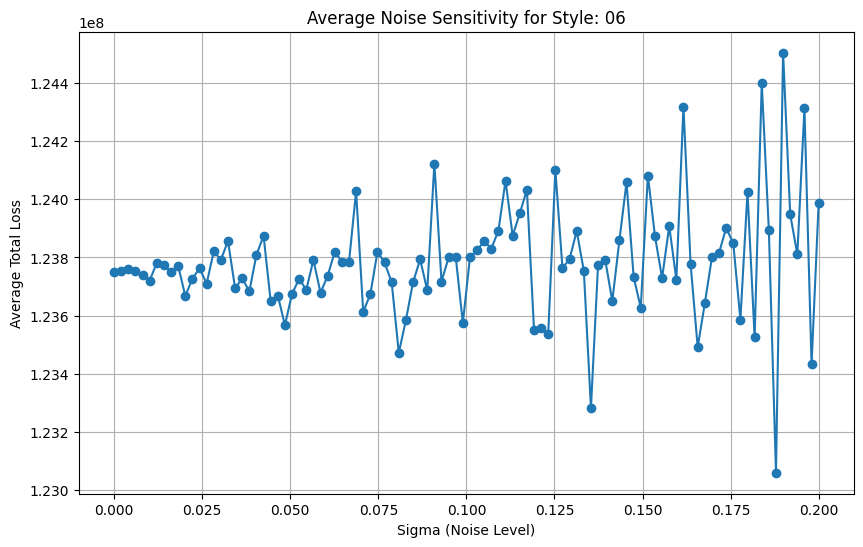

Processing 15: 100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


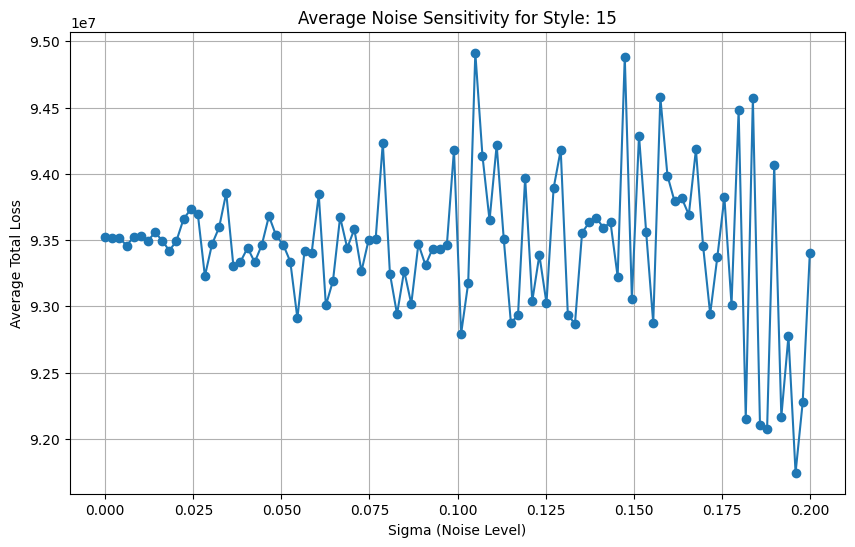

Processing 14: 100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


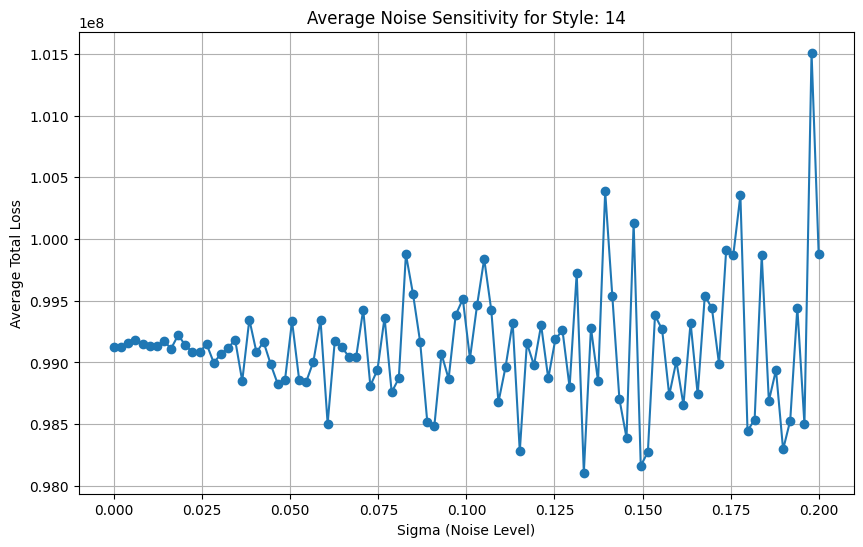

Processing 07: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


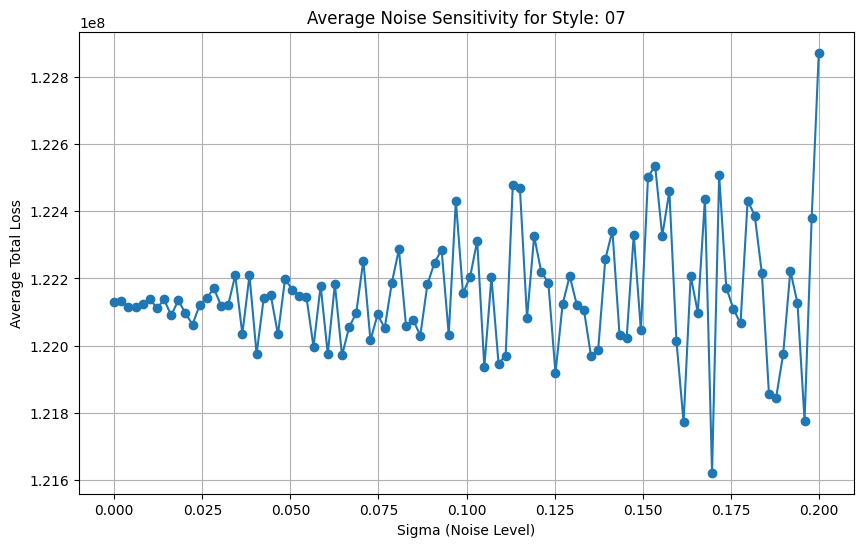

Processing 04: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


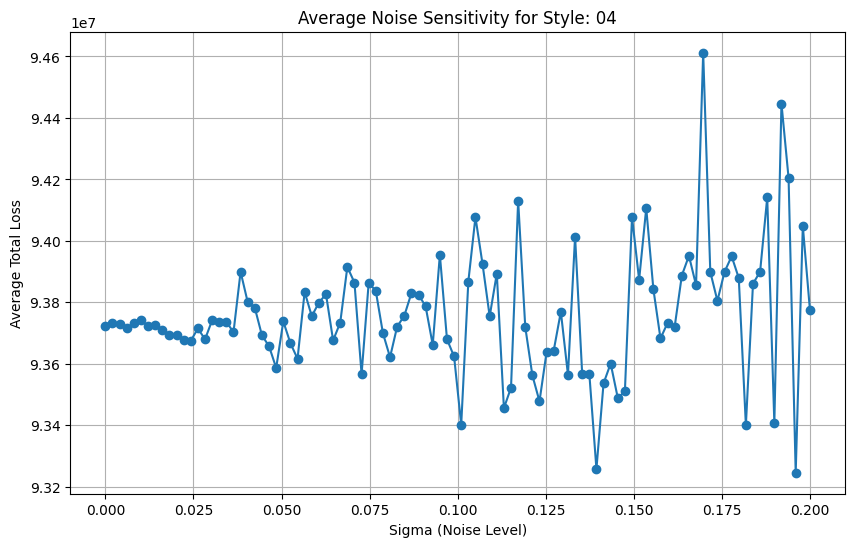

Processing 08: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


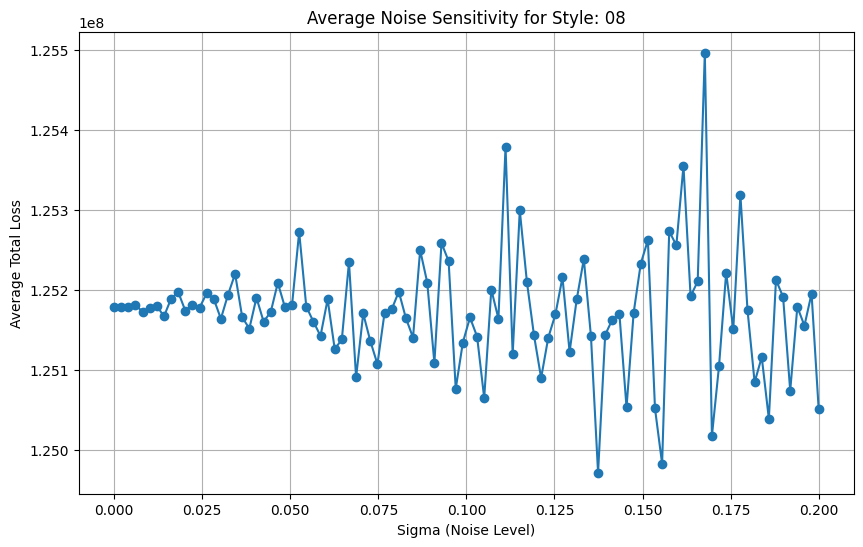

Processing 19: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


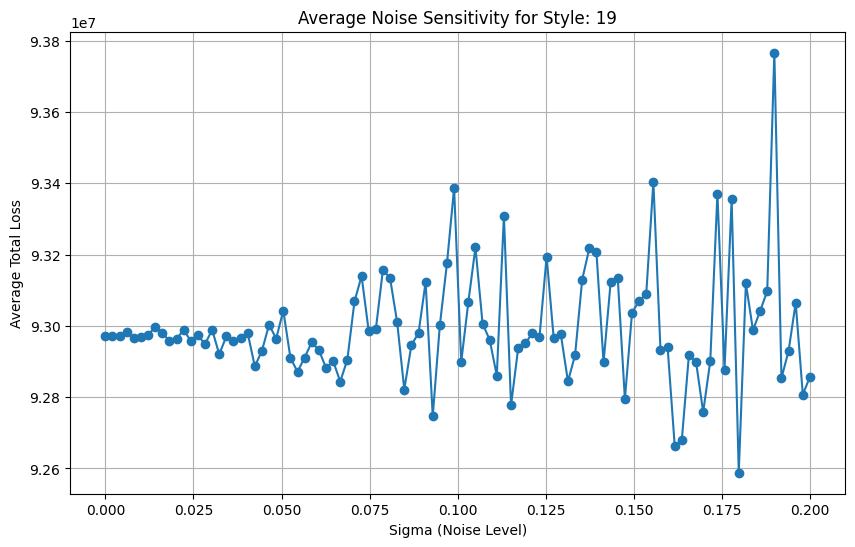

Processing 09: 100%|██████████| 16/16 [00:19<00:00,  1.22s/it]


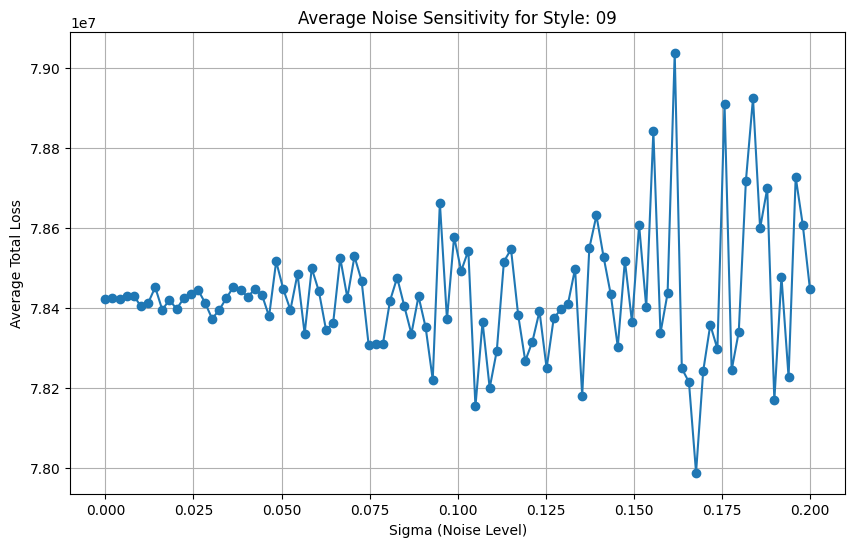

Processing 12: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it]


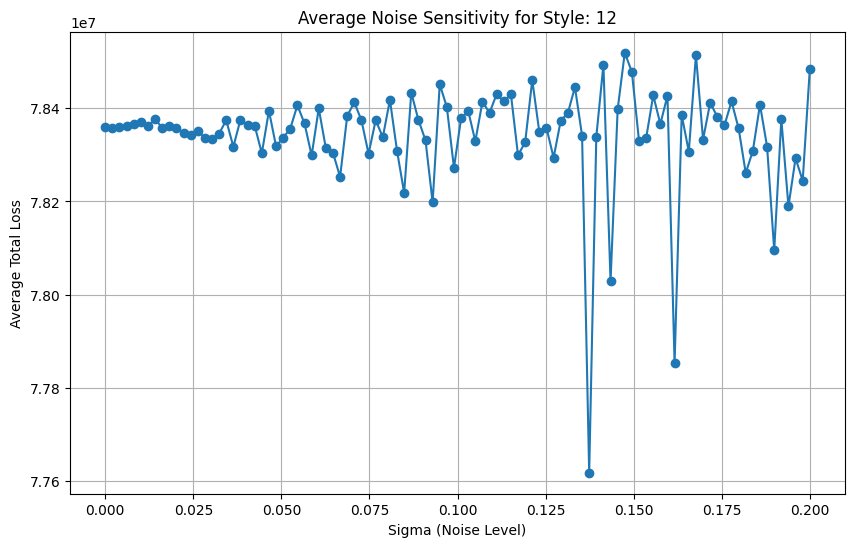

Processing 21: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it]


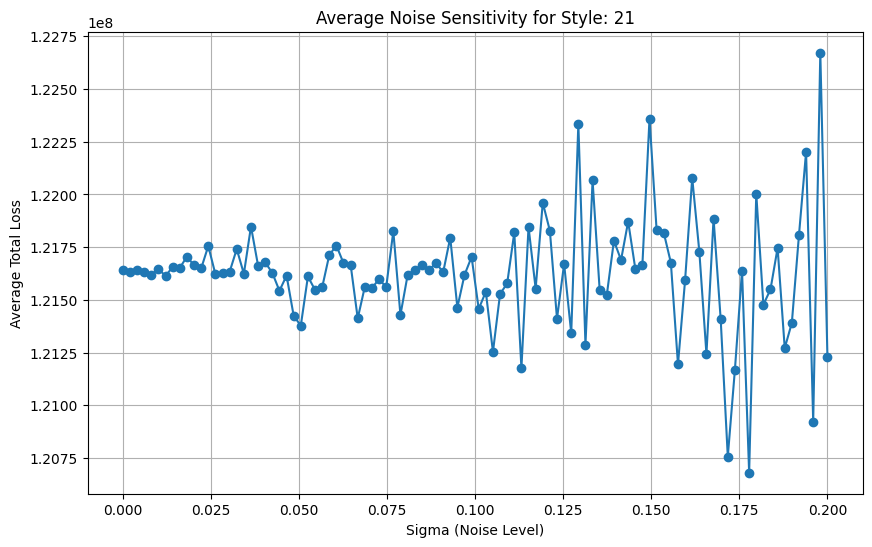

Processing 18: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it]


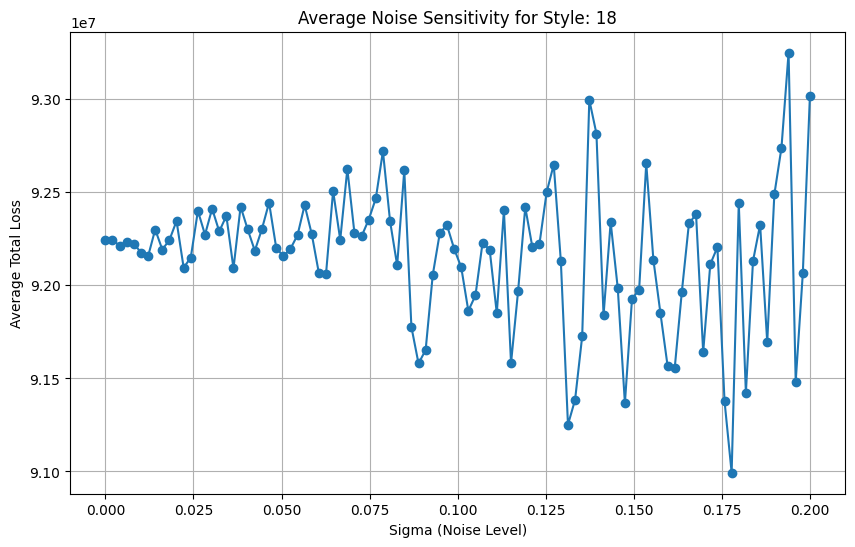

Processing 13: 100%|██████████| 16/16 [00:19<00:00,  1.21s/it]


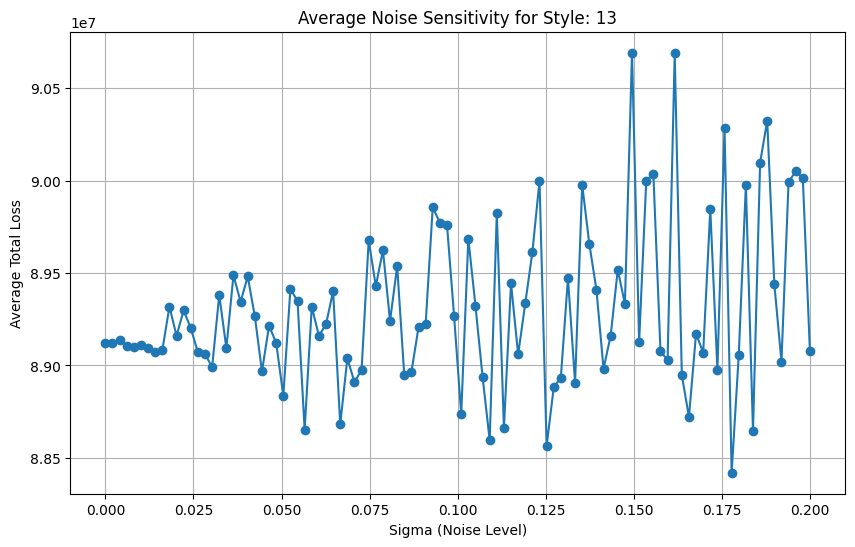

Processing 20: 100%|██████████| 16/16 [00:19<00:00,  1.20s/it]


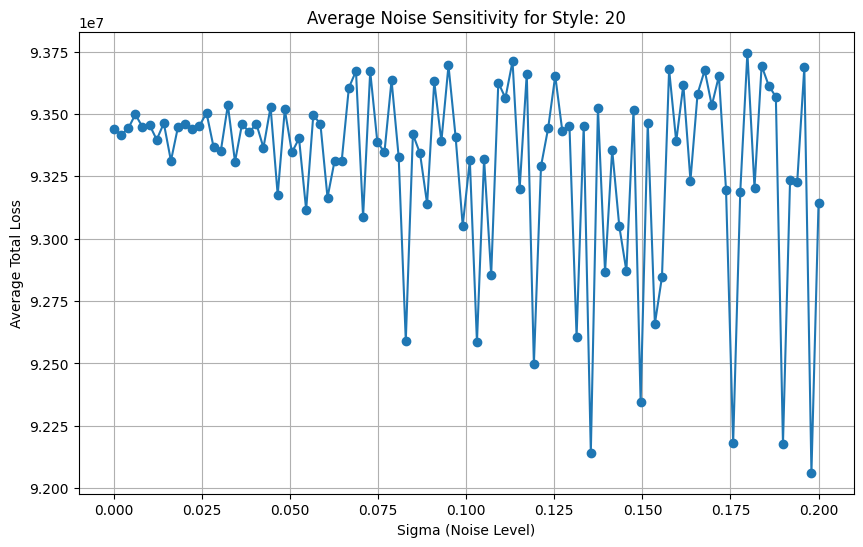

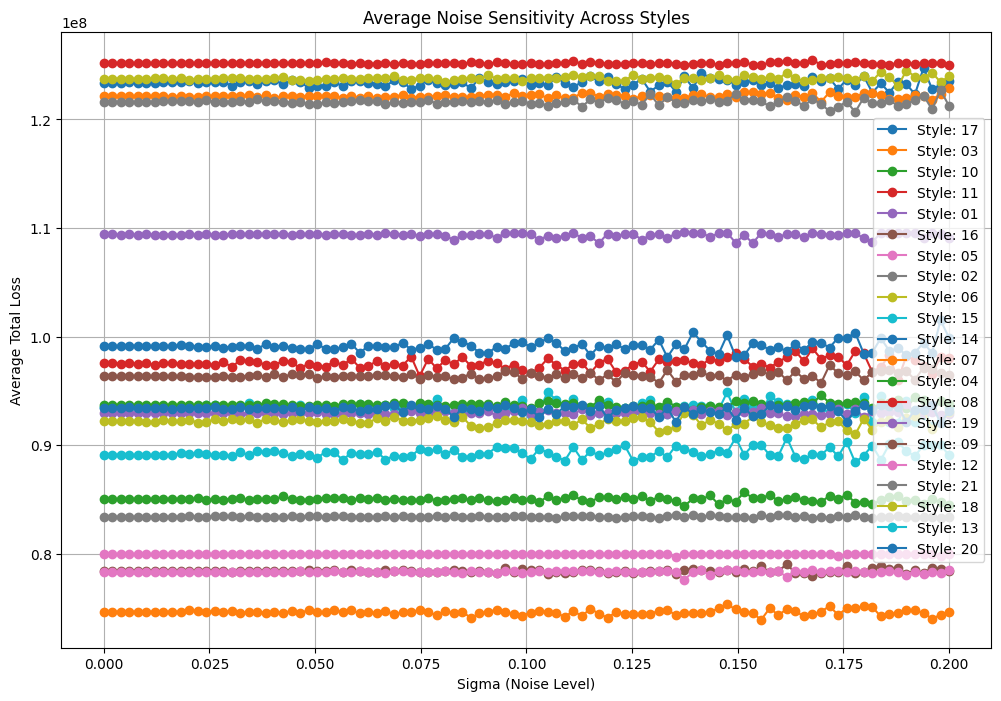

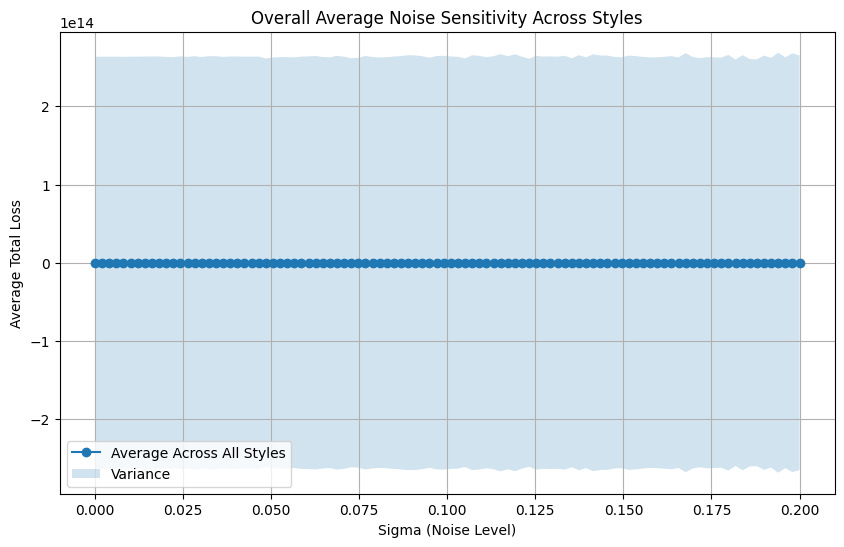

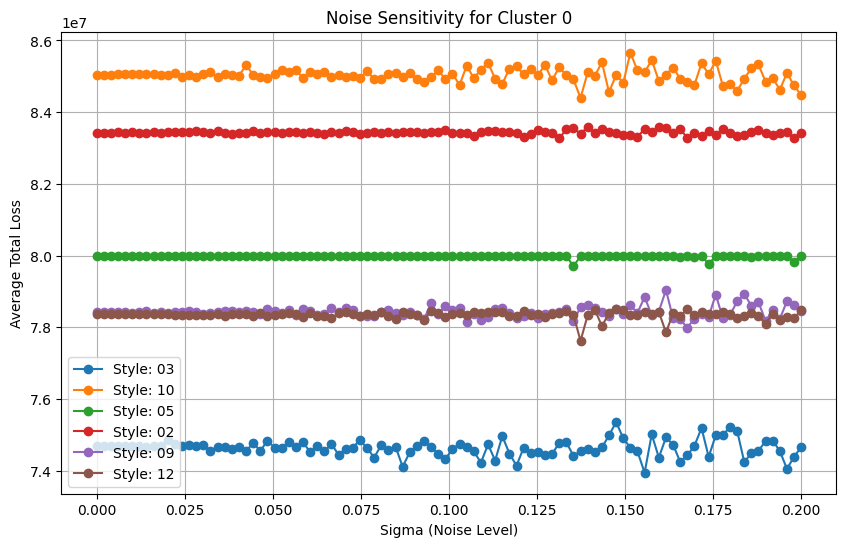

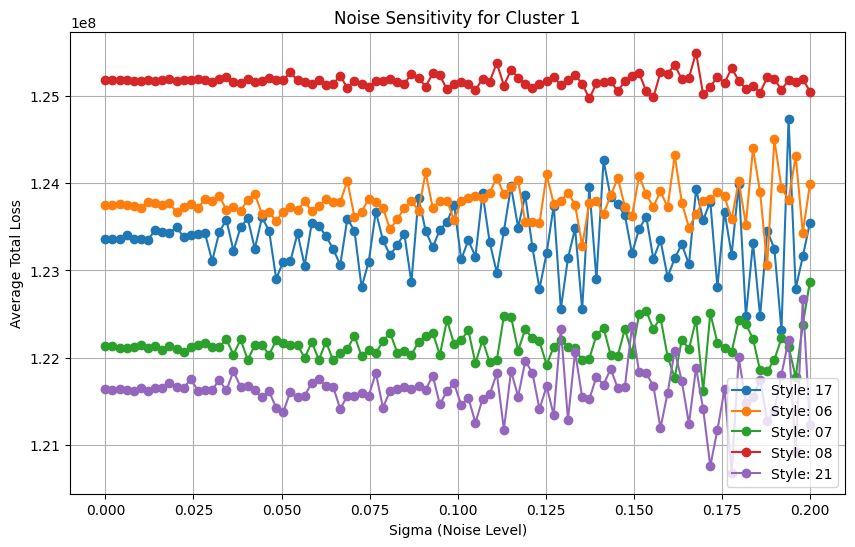

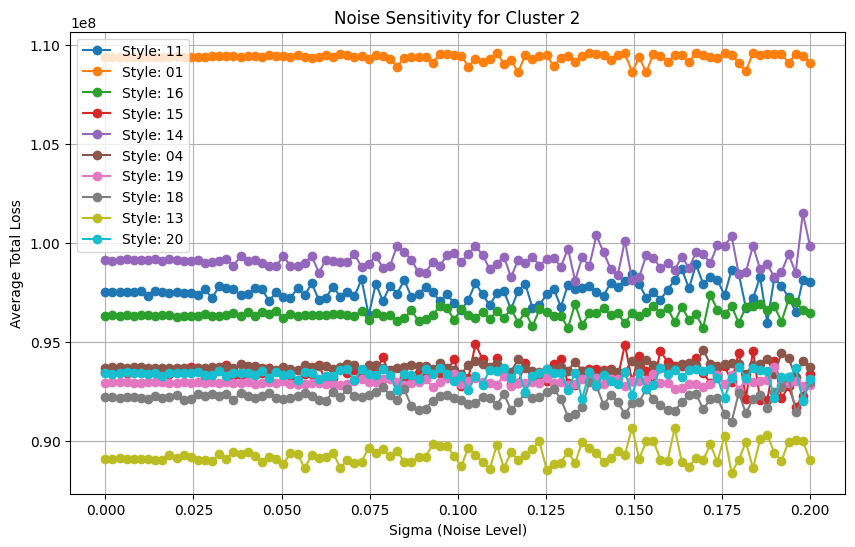

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from libs.Loader import Dataset
from libs.models import encoder4, decoder4
from libs.Criterion import LossCriterion
from libs.Matrix import MulLayer
import os
from typing import List, Tuple
from tqdm import tqdm
from sklearn.cluster import KMeans

class LossSensitivity:
    def __init__(self, vgg: nn.Module, dec: nn.Module, matrix: MulLayer,
                 style_layers: List[str], content_layers: List[str],
                 style_weight: float, content_weight: float, device: torch.device):
        self.vgg = vgg.to(device)
        self.dec = dec.to(device)
        self.matrix = matrix.to(device)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.criterion = LossCriterion(style_layers, content_layers, style_weight, content_weight)
        self.device = device

    def add_noise(self, matrix: torch.Tensor, sigma: float) -> torch.Tensor:
        return matrix + torch.randn_like(matrix) * sigma

    @torch.no_grad()
    def forward(self, contentV: torch.Tensor, styleV: torch.Tensor) -> Tuple[dict, dict]:
        return self.vgg(styleV), self.vgg(contentV)

    def compute_loss(self, contentV: torch.Tensor, styleV: torch.Tensor, noisy_matrix: torch.Tensor) -> float:
        sF, cF = self.forward(contentV, styleV)
        
        transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
        b, c, h, w = transformed_features.size()
        compressed_features = self.matrix.compress(transformed_features)
        
        if noisy_matrix.size(1) != compressed_features.view(b, self.matrix.matrixSize, -1).size(1):
            print(f"Dimension mismatch: {noisy_matrix.size()} vs {compressed_features.size()}")
            return float('inf')
        
        noisy_transfeature = torch.bmm(noisy_matrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        noisy_transfeature = noisy_transfeature.view(b, self.matrix.matrixSize, h, w)
        noisy_transfeature = self.matrix.unzip(noisy_transfeature)
        
        noisy_transfer = self.dec(noisy_transfeature).clamp(0, 1)
        tF = self.vgg(noisy_transfer)
        
        total_loss, _, _ = self.criterion(tF, sF, cF)
        return total_loss.item()

    def compute_matrix_metrics(self, original_matrix: torch.Tensor, noisy_matrix: torch.Tensor) -> Tuple[float, Tuple[torch.Tensor, torch.Tensor], Tuple[torch.Tensor, torch.Tensor]]:
        # Frobenius Norm Difference
        frobenius_diff = torch.norm(original_matrix - noisy_matrix, p='fro').item()
        
        # Eigenvalue/Eigenvector Changes
        orig_eigenvalues, orig_eigenvectors = torch.linalg.eig(original_matrix)
        noisy_eigenvalues, noisy_eigenvectors = torch.linalg.eig(noisy_matrix)
        
        return frobenius_diff, (orig_eigenvalues, noisy_eigenvalues), (orig_eigenvectors, noisy_eigenvectors)

    def run_experiment(self, contentV: torch.Tensor, styleV: torch.Tensor,
                       sigmas: np.ndarray, matrix: torch.Tensor) -> Tuple[List[float], List[float], List[float], List[Tuple[torch.Tensor, torch.Tensor]], List[Tuple[torch.Tensor, torch.Tensor]]]:
        sigma_values = []
        loss_values = []
        frobenius_diffs = []
        eigenvalue_changes = []
        eigenvector_changes = []

        for sigma in sigmas:
            noisy_matrix = self.add_noise(matrix, sigma)
            loss = self.compute_loss(contentV, styleV, noisy_matrix)
            if loss == float('inf'):
                print(f"Skipping sigma {sigma} due to dimension mismatch.")
                continue
            
            frobenius_diff, eigenvalues, eigenvectors = self.compute_matrix_metrics(matrix, noisy_matrix)
            
            sigma_values.append(sigma)
            loss_values.append(loss)
            frobenius_diffs.append(frobenius_diff)
            eigenvalue_changes.append(eigenvalues)
            eigenvector_changes.append(eigenvectors)

        return sigma_values, loss_values, frobenius_diffs, eigenvalue_changes, eigenvector_changes

def process_style_dir(style_dir: str, opt, loss_sensitivity: LossSensitivity,
                      sigmas: np.ndarray, device: torch.device) -> Tuple[List[List[float]], List[List[float]], List[List[Tuple[torch.Tensor, torch.Tensor]]], List[List[Tuple[torch.Tensor, torch.Tensor]]]]:
    style_path = os.path.join(opt.matrixPath, style_dir)
    matrix_files = [f for f in os.listdir(style_path) if f.endswith('.pth')]
    all_loss_values = []
    all_frobenius_diffs = []
    all_eigenvalue_changes = []
    all_eigenvector_changes = []

    content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
    style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)
    contentV, _ = content_dataset[0]
    styleV, _ = style_dataset[0]
    contentV = contentV.unsqueeze(0).to(device)
    styleV = styleV.unsqueeze(0).to(device)

    for matrix_file in tqdm(matrix_files, desc=f"Processing {style_dir}"):
        matrix_path = os.path.join(style_path, matrix_file)
        saved_matrix = torch.load(matrix_path, map_location=device)
        _, loss_values, frobenius_diffs, eigenvalue_changes, eigenvector_changes = loss_sensitivity.run_experiment(contentV, styleV, sigmas, saved_matrix)
        all_loss_values.append(loss_values)
        all_frobenius_diffs.append(frobenius_diffs)
        all_eigenvalue_changes.append(eigenvalue_changes)
        all_eigenvector_changes.append(eigenvector_changes)

    return all_loss_values, all_frobenius_diffs, all_eigenvalue_changes, all_eigenvector_changes

def plot_style_results(style_dir: str, sigmas: np.ndarray, avg_loss_values: np.ndarray, avg_frobenius_diffs: np.ndarray):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    ax1.plot(sigmas[:len(avg_loss_values)], avg_loss_values, '-o')
    ax1.set_xlabel('Sigma (Noise Level)')
    ax1.set_ylabel('Average Total Loss')
    ax1.set_title(f'Average Noise Sensitivity for Style: {style_dir}')
    ax1.grid(True)
    
    ax2.plot(sigmas[:len(avg_frobenius_diffs)], avg_frobenius_diffs, '-o')
    ax2.set_xlabel('Sigma (Noise Level)')
    ax2.set_ylabel('Average Frobenius Norm Difference')
    ax2.set_title(f'Average Matrix Change for Style: {style_dir}')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'noise_sensitivity_{style_dir}.png')
    plt.show()

def analyze_eigenvalue_changes(style_dir: str, sigmas: np.ndarray, eigenvalue_changes: List[Tuple[torch.Tensor, torch.Tensor]]):
    avg_eigenvalue_diffs = []
    for orig, noisy in eigenvalue_changes:
        avg_diff = torch.mean(torch.abs(orig - noisy)).item()
        avg_eigenvalue_diffs.append(avg_diff)
    
    plt.figure(figsize=(10, 6))
    plt.plot(sigmas, avg_eigenvalue_diffs, '-o')
    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Average Eigenvalue Difference')
    plt.title(f'Eigenvalue Sensitivity for Style: {style_dir}')
    plt.grid(True)
    plt.savefig(f'eigenvalue_sensitivity_{style_dir}.png')
    plt.show()
    
def plot_average_frobenius_norm_trend(sigmas: np.ndarray, all_styles_frobenius_diffs: List[np.ndarray]):
    """
    Plot the average Frobenius norm trend across all styles.
    
    :param sigmas: Array of noise levels
    :param all_styles_frobenius_diffs: List of Frobenius norm differences for each style
    """
    avg_frobenius_diffs = np.mean(all_styles_frobenius_diffs, axis=0)
    std_frobenius_diffs = np.std(all_styles_frobenius_diffs, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(sigmas, avg_frobenius_diffs, '-o', label='Average')
    plt.fill_between(sigmas, 
                     avg_frobenius_diffs - std_frobenius_diffs, 
                     avg_frobenius_diffs + std_frobenius_diffs, 
                     alpha=0.2, label='Standard Deviation')
    
    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Average Frobenius Norm Difference')
    plt.title('Average Frobenius Norm Trend Across All Styles')
    plt.legend()
    plt.grid(True)
    plt.savefig('average_frobenius_norm_trend.png')
    plt.show()   

def identify_sensitive_components(style_dir: str, sigmas: np.ndarray, eigenvalue_changes: List[Tuple[torch.Tensor, torch.Tensor]]):
    num_eigenvalues = eigenvalue_changes[0][0].shape[0]
    eigenvalue_sensitivities = [[] for _ in range(num_eigenvalues)]
    
    for orig, noisy in eigenvalue_changes:
        diffs = torch.abs(orig - noisy)
        for i in range(num_eigenvalues):
            eigenvalue_sensitivities[i].append(diffs[i].item())
    
    plt.figure(figsize=(12, 8))
    for i in range(num_eigenvalues):
        plt.plot(sigmas, eigenvalue_sensitivities[i], label=f'Eigenvalue {i+1}')
    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Eigenvalue Difference')
    plt.title(f'Individual Eigenvalue Sensitivities for Style: {style_dir}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'individual_eigenvalue_sensitivities_{style_dir}.png')
    plt.show()

class Options:
    
    def __init__(self):
        self.contentPath = "data/content/"
        self.stylePath = "data/style/"
        self.loadSize = 256
        self.fineSize = 256
        self.matrixPath = "Matrices/"
        
def load_models(device: torch.device) -> Tuple[nn.Module, nn.Module, MulLayer]:
    vgg = encoder4()
    dec = decoder4()
    matrix = MulLayer('r41')
    vgg.load_state_dict(torch.load('models/vgg_r41.pth', map_location=device))
    dec.load_state_dict(torch.load('models/dec_r41.pth', map_location=device))
    return vgg, dec, matrix        

def plot_average_frobenius_norm_trend(sigmas: np.ndarray, all_styles_frobenius_diffs: List[np.ndarray]):
    """
    Plot the average Frobenius norm trend across all styles with standard deviation.
    
    :param sigmas: Array of noise levels
    :param all_styles_frobenius_diffs: List of Frobenius norm differences for each style
    """
    avg_frobenius_diffs = np.mean(all_styles_frobenius_diffs, axis=0)
    std_frobenius_diffs = np.std(all_styles_frobenius_diffs, axis=0)

    plt.figure(figsize=(12, 6))
    plt.plot(sigmas, avg_frobenius_diffs, '-', color='blue', label='Average')
    plt.fill_between(sigmas, 
                     avg_frobenius_diffs - std_frobenius_diffs, 
                     avg_frobenius_diffs + std_frobenius_diffs, 
                     alpha=0.3, color='lightblue', label='±1 Standard Deviation')

    # Plot ±1 standard deviation lines
    plt.plot(sigmas, avg_frobenius_diffs - std_frobenius_diffs, '--', color='red', alpha=0.5, label='-1 Std Dev')
    plt.plot(sigmas, avg_frobenius_diffs + std_frobenius_diffs, '--', color='red', alpha=0.5, label='+1 Std Dev')
    
    plt.xlabel('Sigma (Noise Level)')
    plt.ylabel('Average Frobenius Norm Difference')
    plt.title('Average Frobenius Norm Trend Across All Styles')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('average_frobenius_norm_trend.png', dpi=300)
    plt.show()

    # Print some statistics
    print(f"Maximum average Frobenius norm difference: {np.max(avg_frobenius_diffs):.4f}")
    print(f"Maximum standard deviation: {np.max(std_frobenius_diffs):.4f}")
    print(f"Sigma at maximum average difference: {sigmas[np.argmax(avg_frobenius_diffs)]:.4f}")

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vgg, dec, matrix = load_models(device)
    
    style_layers = ['r41']
    content_layers = ['r41']
    style_weight = 1e5
    content_weight = 1.0

    opt = Options()
    loss_sensitivity = LossSensitivity(vgg, dec, matrix, style_layers, content_layers,
                                       style_weight, content_weight, device)

    sigmas = np.linspace(0, 0.2, 100)
    style_dirs = [d for d in os.listdir(opt.matrixPath) if os.path.isdir(os.path.join(opt.matrixPath, d))]
    
    all_styles_frobenius_diffs = []

    for style_dir in style_dirs:
        all_loss_values, all_frobenius_diffs, all_eigenvalue_changes, all_eigenvector_changes = process_style_dir(style_dir, opt, loss_sensitivity, sigmas, device)
        
        if all_loss_values:
            avg_loss_values = np.mean(all_loss_values, axis=0)
            avg_frobenius_diffs = np.mean(all_frobenius_diffs, axis=0)
            all_styles_frobenius_diffs.append(avg_frobenius_diffs)
            plot_style_results(style_dir, sigmas, avg_loss_values, avg_frobenius_diffs)
            
            # ... (rest of the code in the loop remains the same)

    # Plot average Frobenius norm trend across all styles
    if all_styles_frobenius_diffs:
        plot_average_frobenius_norm_trend(sigmas, all_styles_frobenius_diffs)
    else:
        print("Warning: No Frobenius norm data available for analysis across styles.")

if __name__ == "__main__":
    main()

/tmp/ipykernel_27323/3236679623.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load('models/vgg_r41.pth', map_location=device))
/tmp/ipykerne

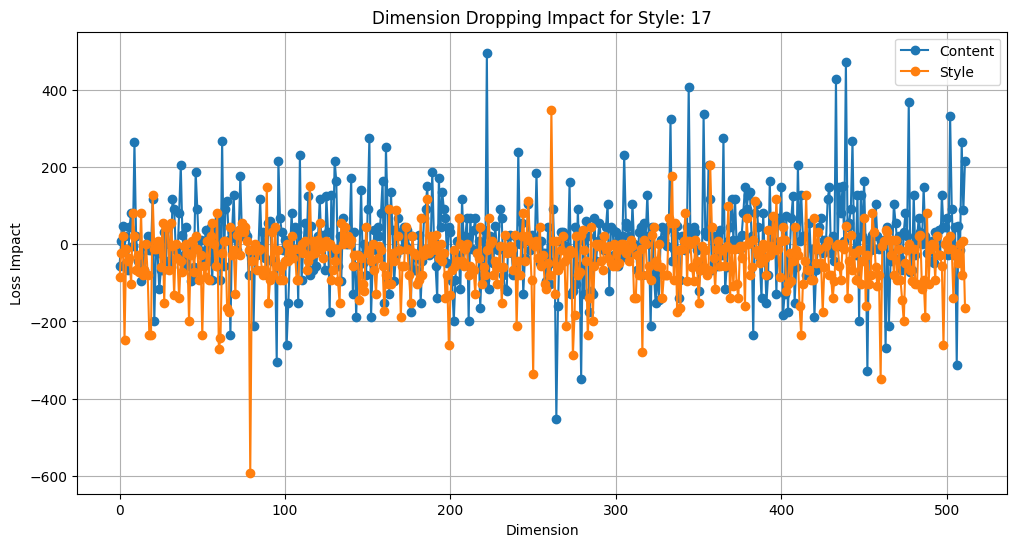

Processing 03: 100%|██████████| 16/16 [03:41<00:00, 13.86s/it]


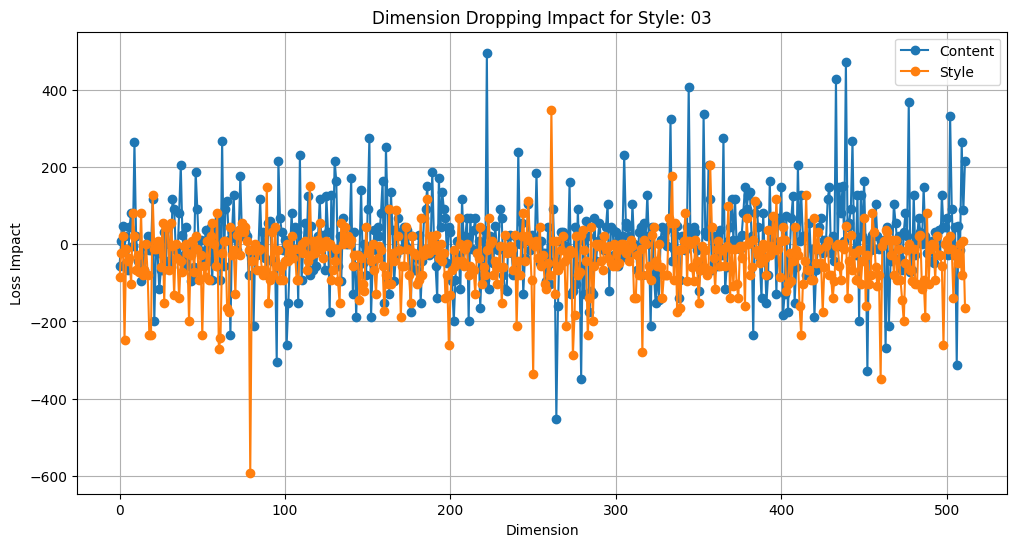

Processing 10: 100%|██████████| 16/16 [03:41<00:00, 13.86s/it]


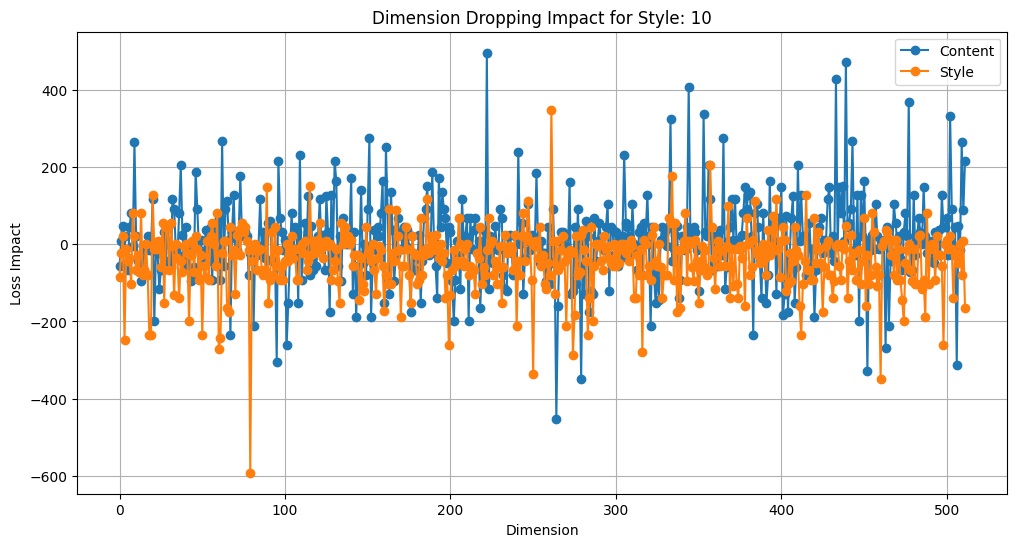

Processing 11: 100%|██████████| 16/16 [03:41<00:00, 13.87s/it]


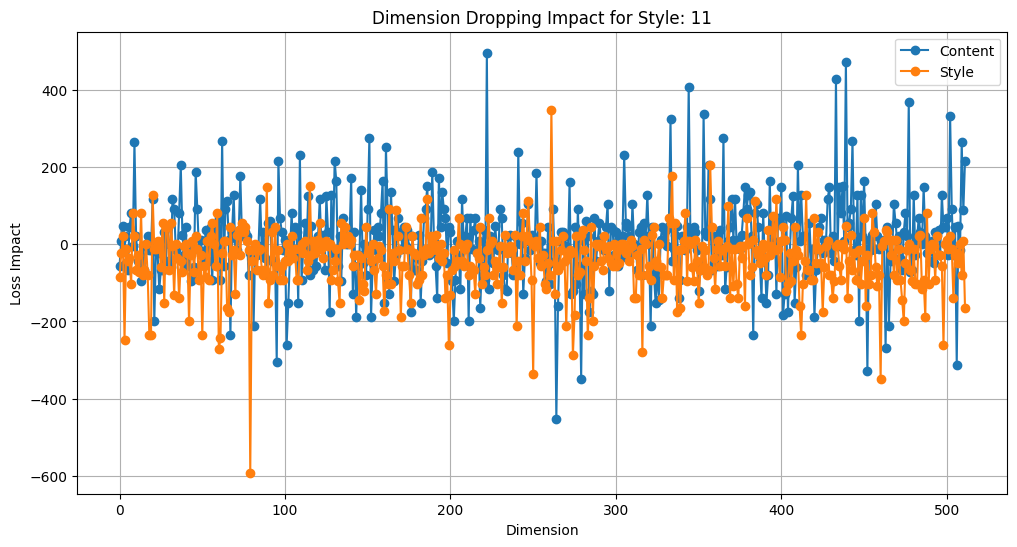

Processing 01: 100%|██████████| 16/16 [03:41<00:00, 13.84s/it]


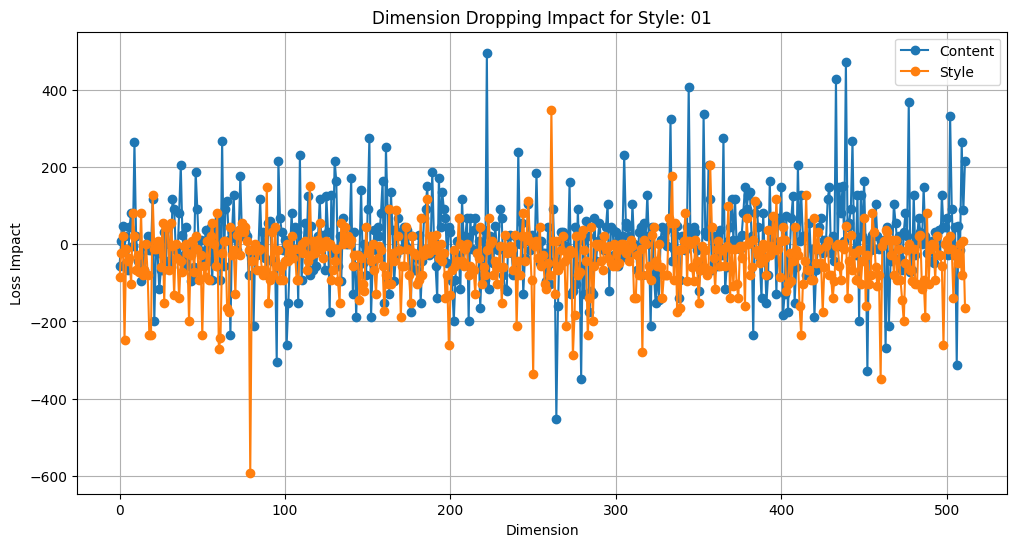

Processing 16: 100%|██████████| 16/16 [03:41<00:00, 13.87s/it]


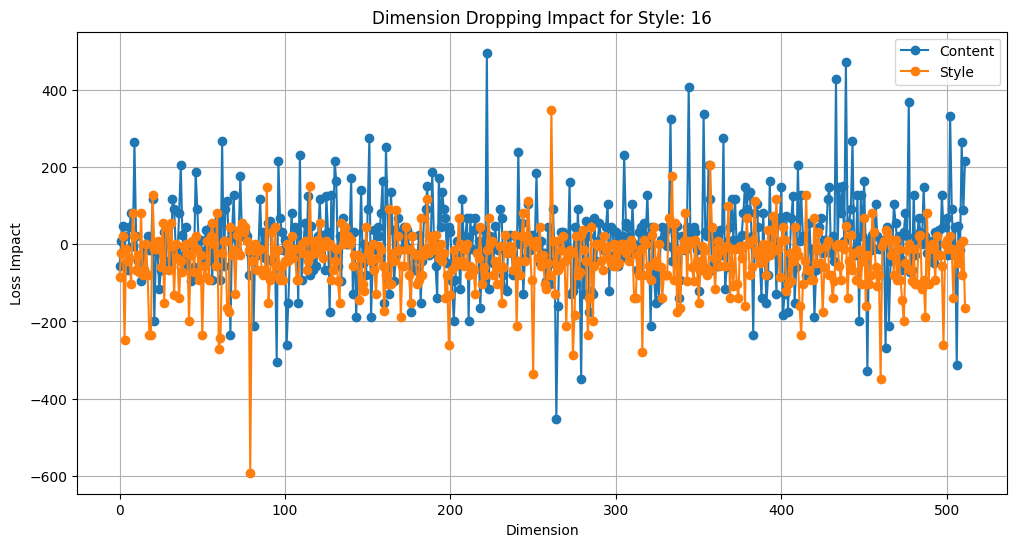

Processing 05: 100%|██████████| 16/16 [03:41<00:00, 13.87s/it]


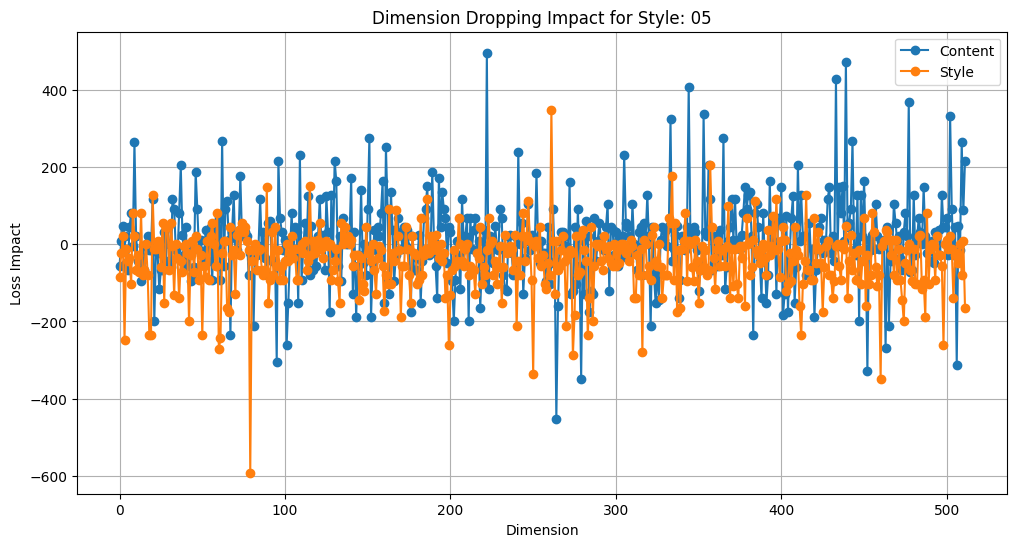

Processing 02: 100%|██████████| 16/16 [03:40<00:00, 13.81s/it]


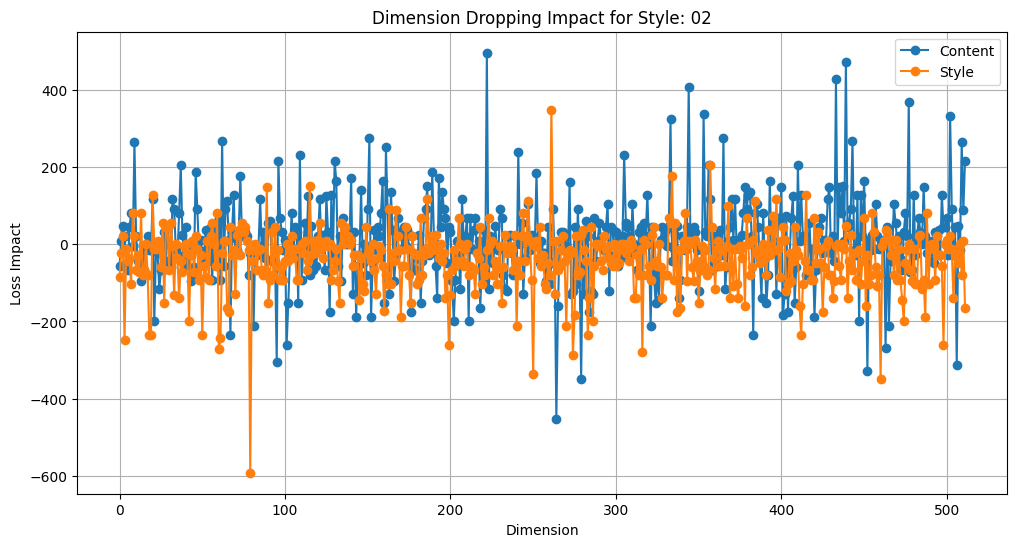

Processing 06: 100%|██████████| 16/16 [03:41<00:00, 13.87s/it]


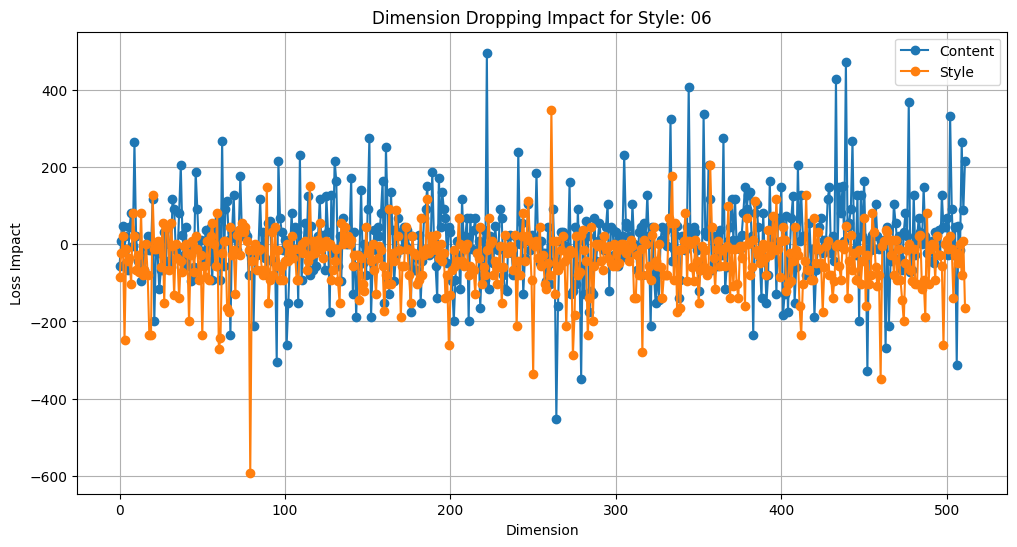

Processing 15: 100%|██████████| 16/16 [03:42<00:00, 13.88s/it]


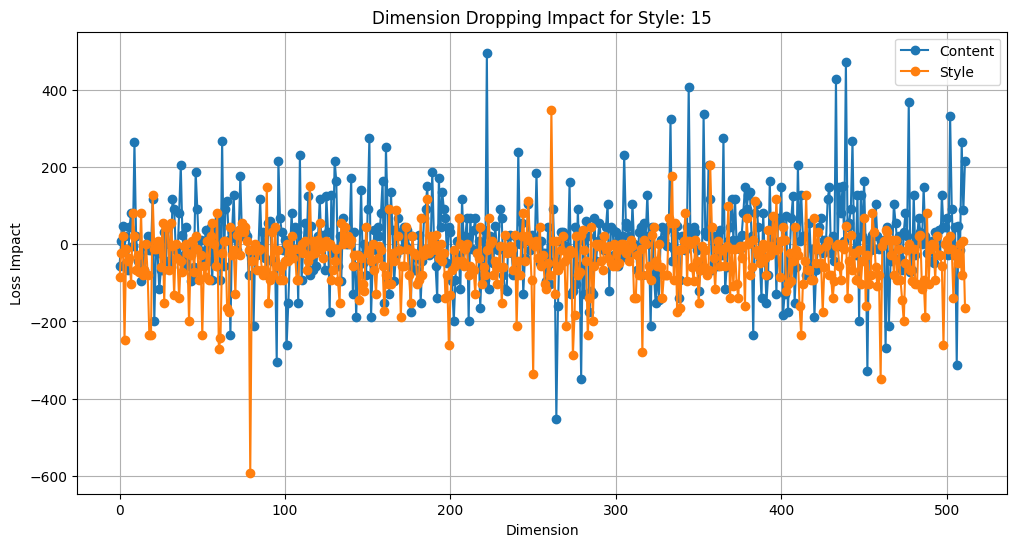

Processing 14: 100%|██████████| 16/16 [03:42<00:00, 13.91s/it]


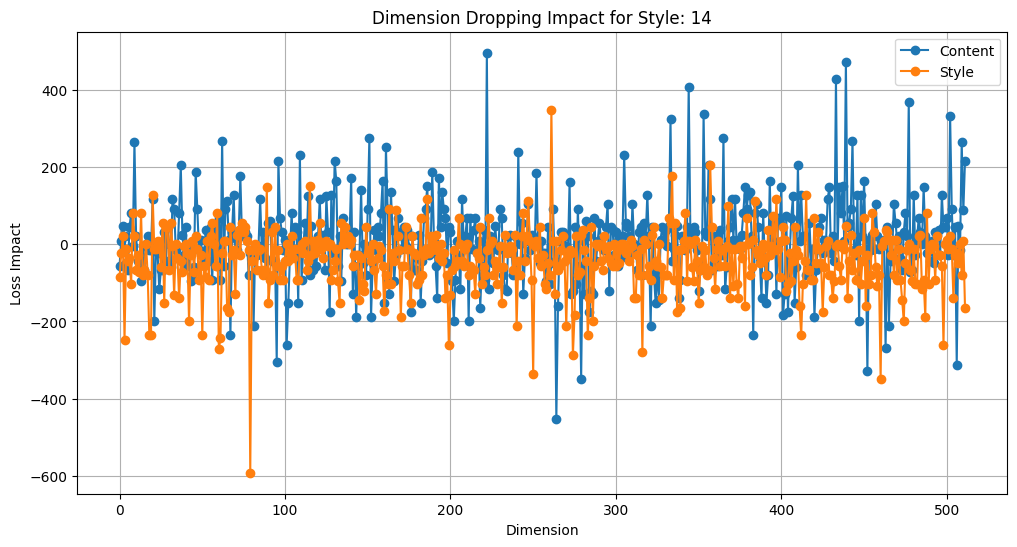

Processing 07: 100%|██████████| 16/16 [03:42<00:00, 13.93s/it]


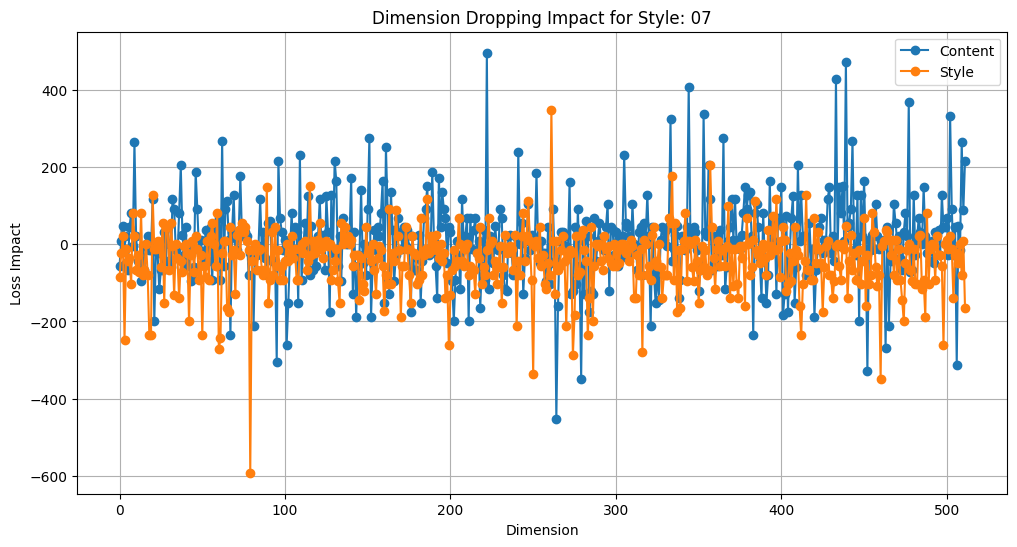

Processing 04: 100%|██████████| 16/16 [03:42<00:00, 13.93s/it]


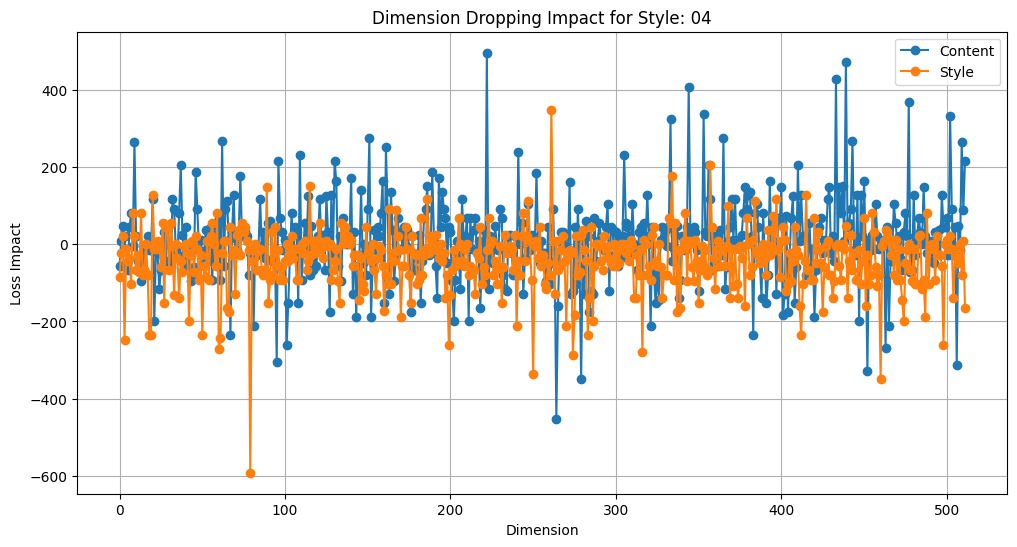

Processing 08: 100%|██████████| 16/16 [03:43<00:00, 13.94s/it]


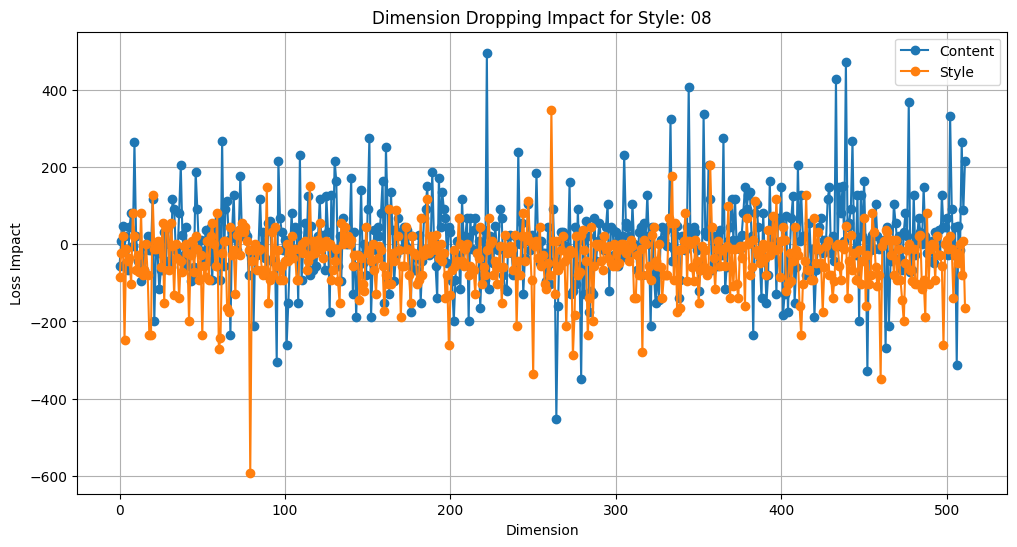

Processing 19: 100%|██████████| 16/16 [03:42<00:00, 13.93s/it]


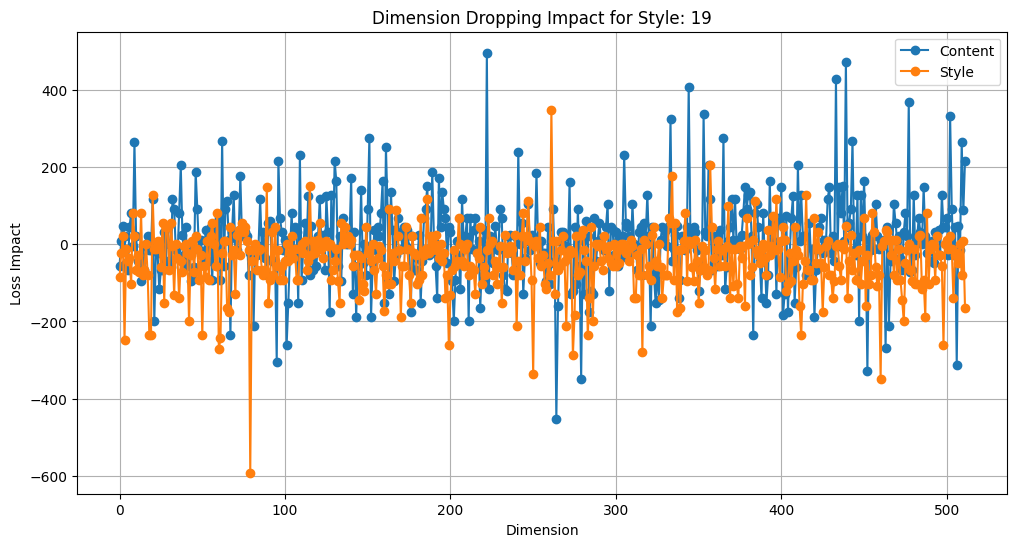

Processing 09: 100%|██████████| 16/16 [03:43<00:00, 13.94s/it]


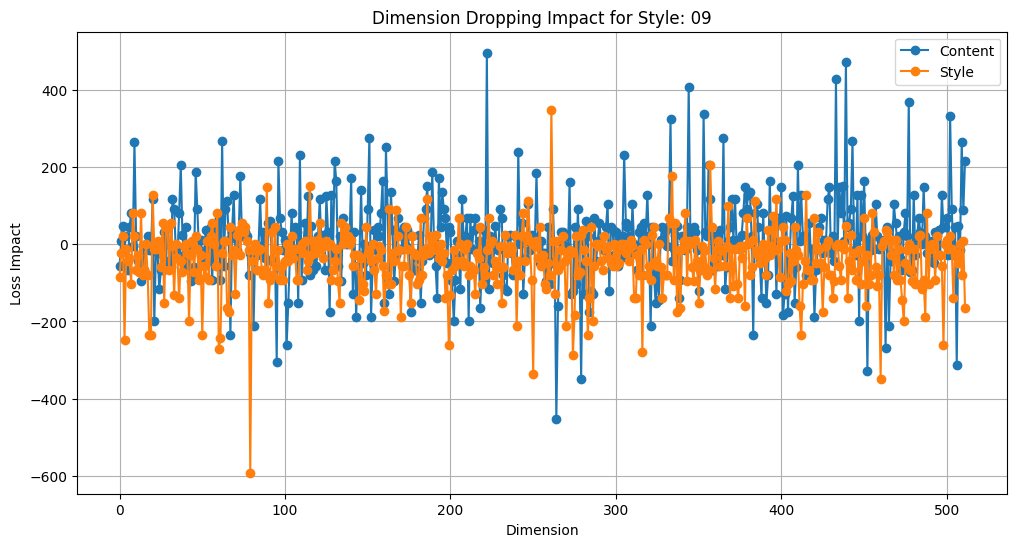

Processing 12: 100%|██████████| 16/16 [03:43<00:00, 13.94s/it]


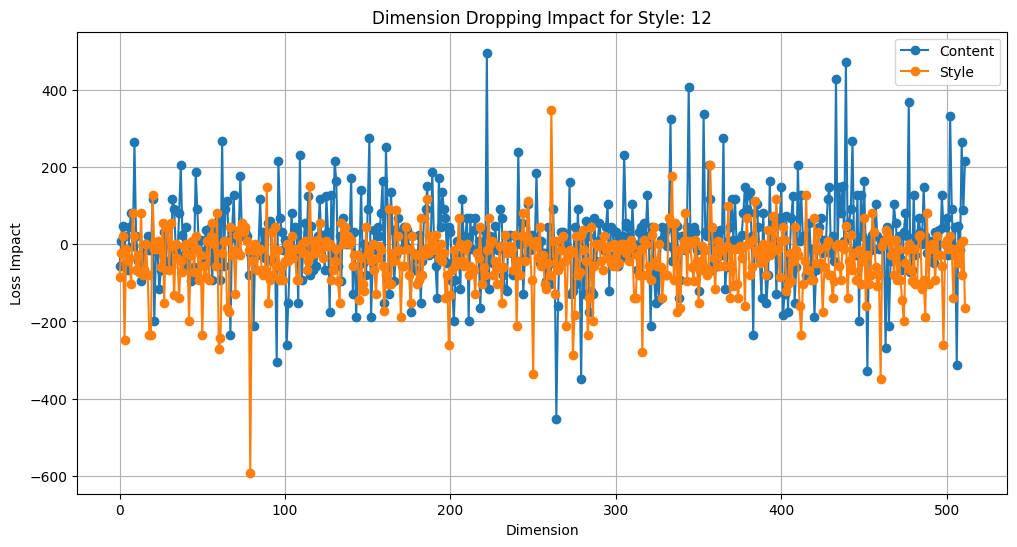

Processing 21: 100%|██████████| 16/16 [03:43<00:00, 13.94s/it]


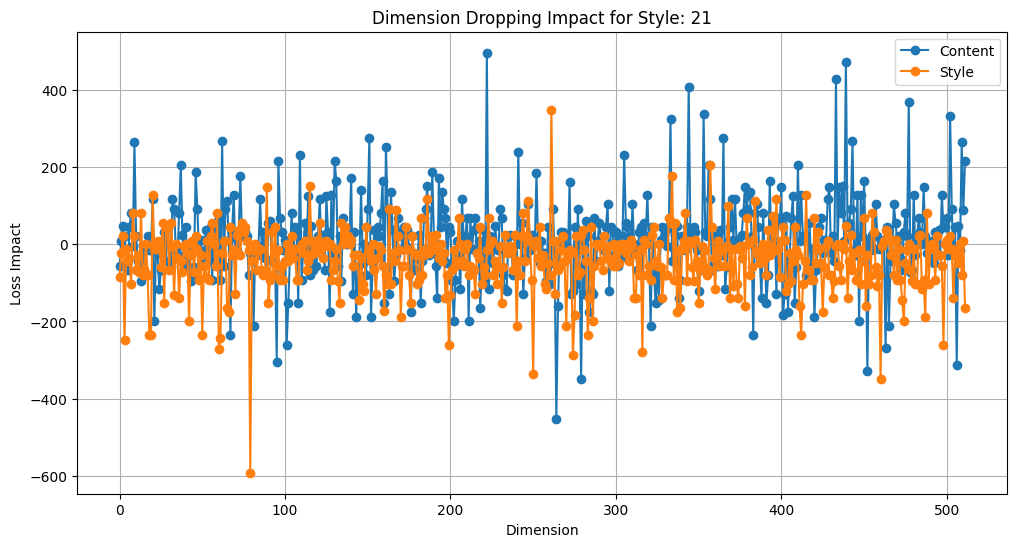

Processing 18: 100%|██████████| 16/16 [03:43<00:00, 13.94s/it]


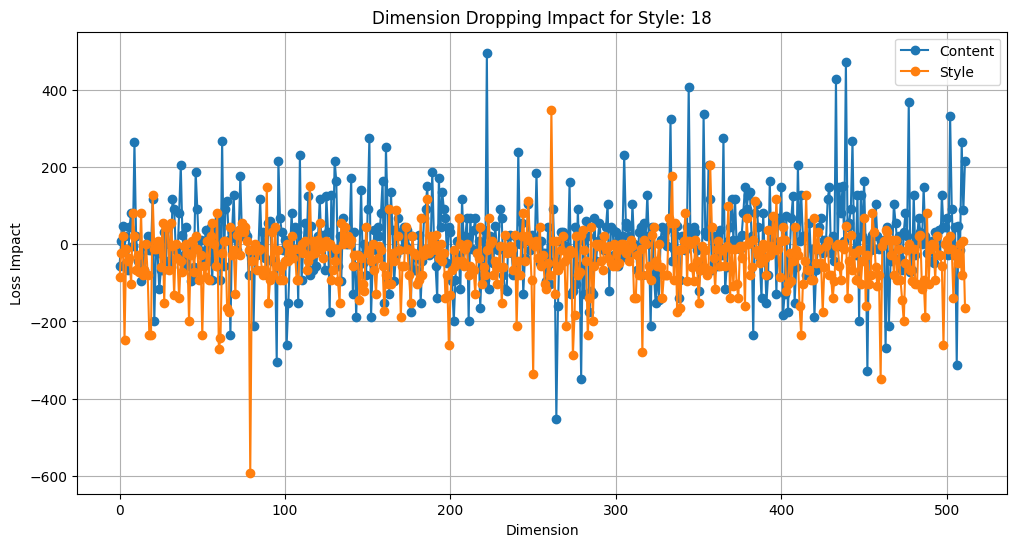

Processing 13: 100%|██████████| 16/16 [03:42<00:00, 13.92s/it]


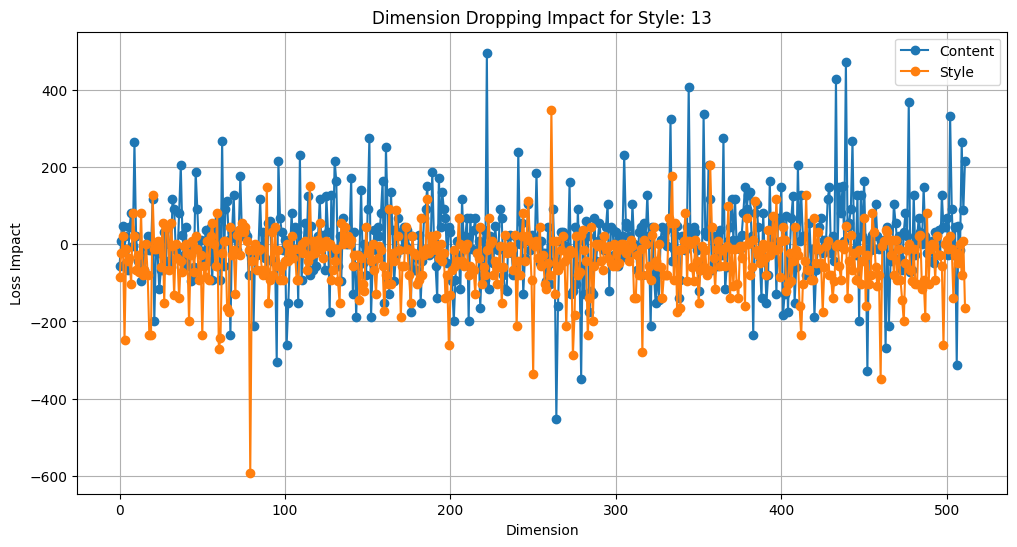

Processing 20: 100%|██████████| 16/16 [03:42<00:00, 13.93s/it]


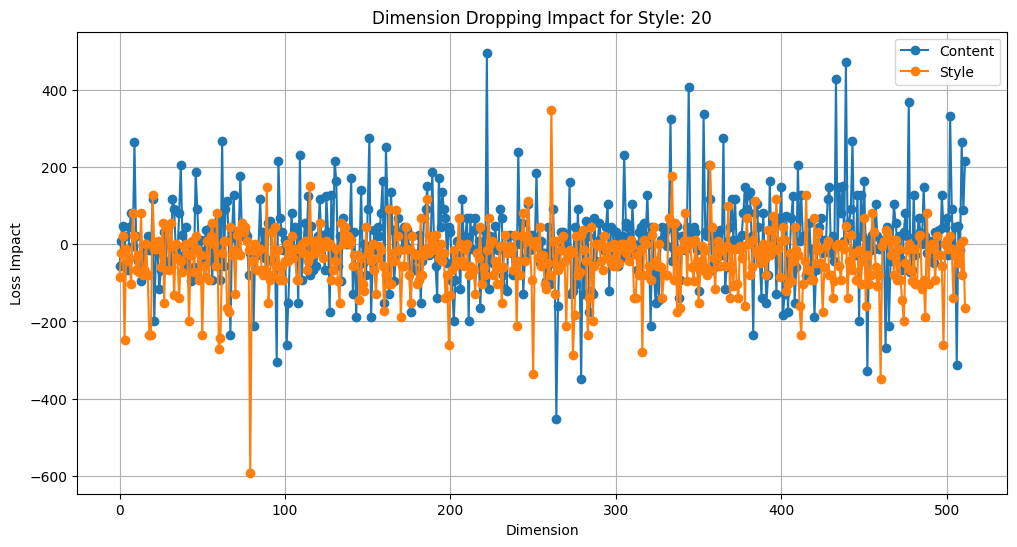

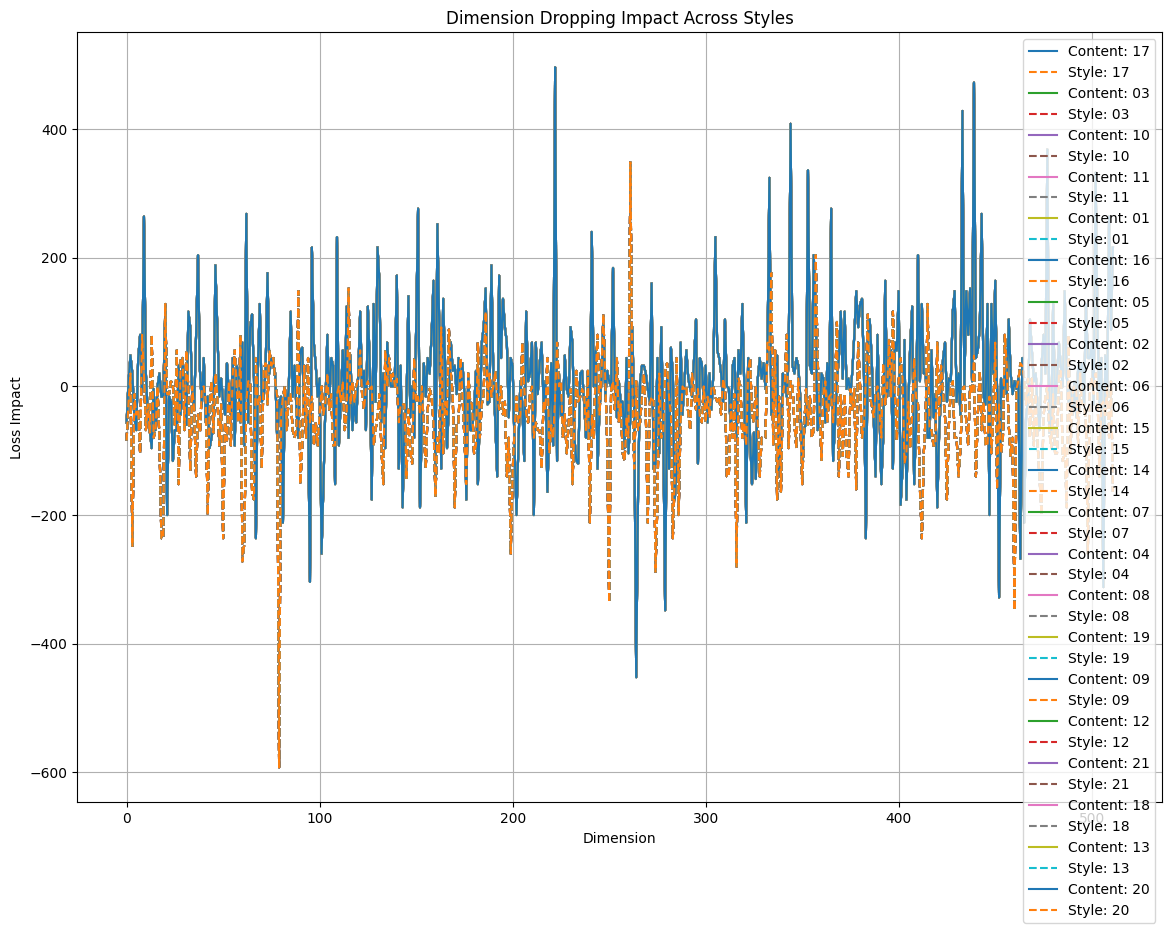

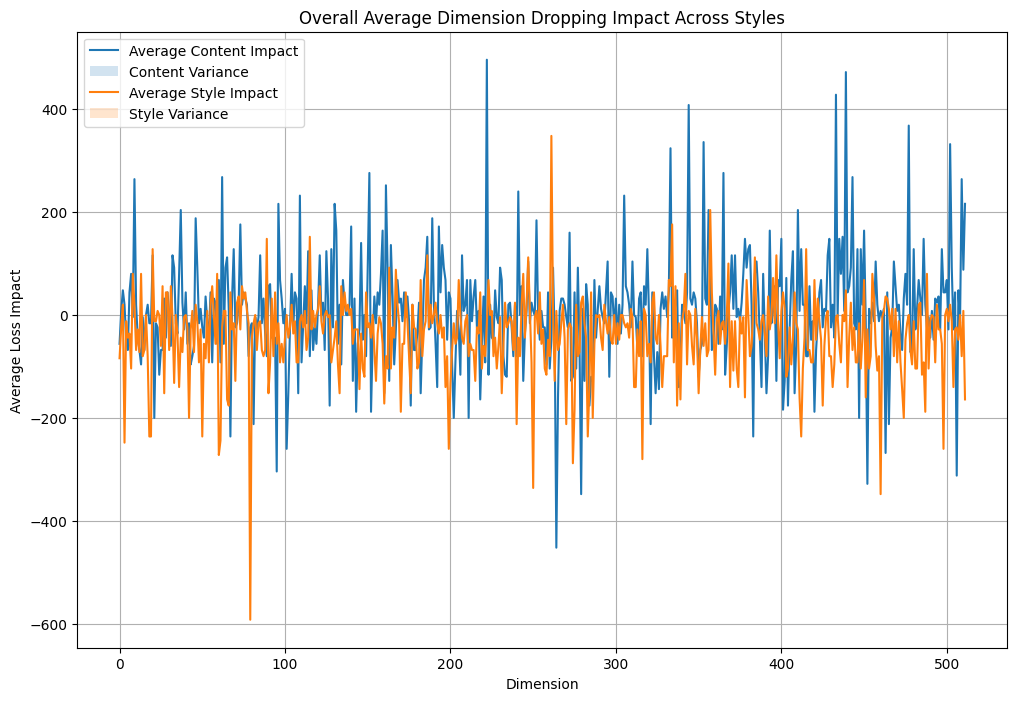

/home2/sunayana981/miniconda3/envs/myenv/lib/python3.10/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


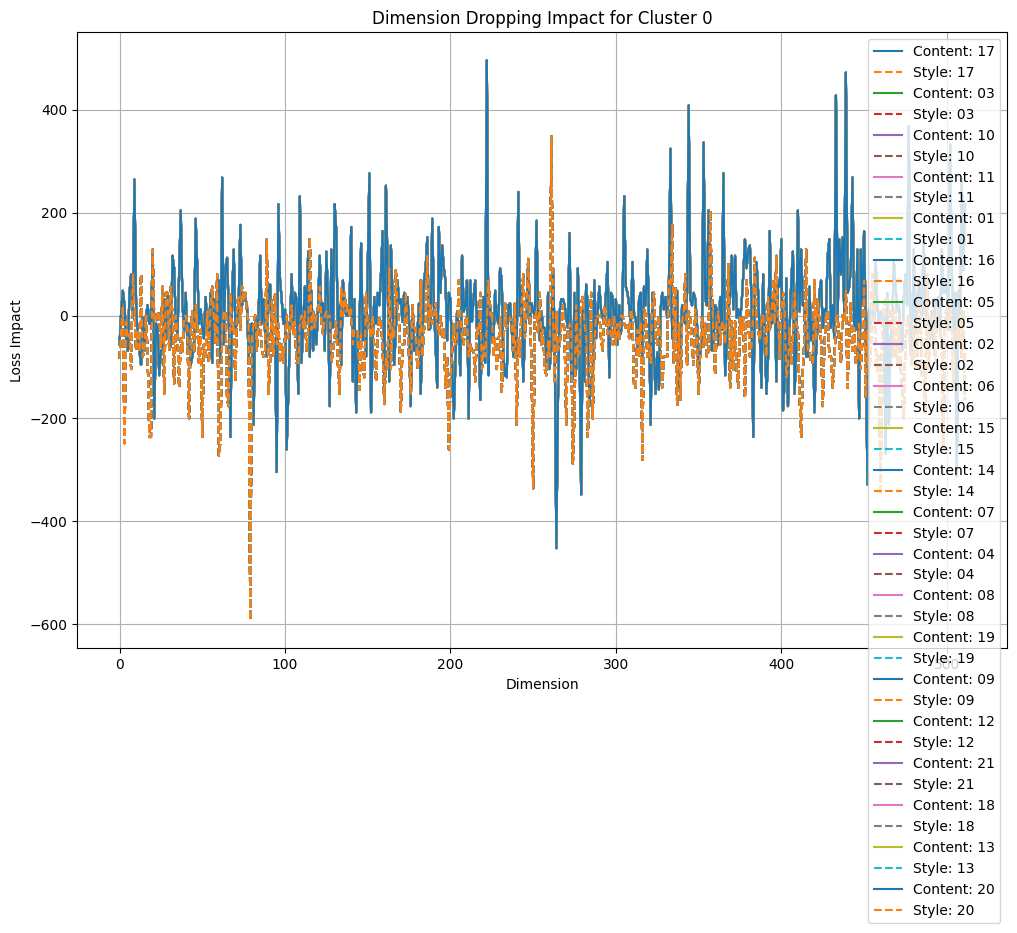

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import List, Tuple
from tqdm import tqdm
from sklearn.cluster import KMeans

class LossSensitivity:
    def __init__(self, vgg: nn.Module, dec: nn.Module, matrix: MulLayer, 
                 style_layers: List[str], content_layers: List[str], 
                 style_weight: float, content_weight: float, device: torch.device):
        self.vgg = vgg.to(device)
        self.dec = dec.to(device)
        self.matrix = matrix.to(device)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.criterion = LossCriterion(style_layers, content_layers, style_weight, content_weight)
        self.device = device

    @torch.no_grad()
    def forward(self, contentV: torch.Tensor, styleV: torch.Tensor) -> Tuple[dict, dict]:
        return self.vgg(styleV), self.vgg(contentV)

    def compute_loss(self, contentV: torch.Tensor, styleV: torch.Tensor, transmatrix: torch.Tensor) -> float:
        sF, cF = self.forward(contentV, styleV)
        
        transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
        b, c, h, w = transformed_features.size()
        compressed_features = self.matrix.compress(transformed_features)
        
        transfeature = torch.bmm(transmatrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        transfeature = transfeature.view(b, self.matrix.matrixSize, h, w)
        transfeature = self.matrix.unzip(transfeature)
        
        transfer = self.dec(transfeature).clamp(0, 1)
        tF = self.vgg(transfer)
        
        total_loss, _, _ = self.criterion(tF, sF, cF)
        return total_loss.item()

    def run_dimension_dropping_experiment(self, contentV: torch.Tensor, styleV: torch.Tensor) -> Tuple[List[float], List[float]]:
        sF, cF = self.forward(contentV, styleV)
        
        content_features = cF[self.style_layers[0]]
        style_features = sF[self.style_layers[0]]
        
        b, c, h, w = content_features.size()
        
        content_loss_impacts = []
        style_loss_impacts = []
        
        # Calculate baseline loss
        _, baseline_matrix = self.matrix(content_features, style_features)
        baseline_loss = self.compute_loss(contentV, styleV, baseline_matrix)
        
        # Analyze content dimensions
        for dim in tqdm(range(c), desc="Analyzing content dimensions"):
            dropped_content = content_features.clone()
            dropped_content[:, dim, :, :] = 0
            
            _, transmatrix = self.matrix(dropped_content, style_features)
            loss = self.compute_loss(contentV, styleV, transmatrix)
            content_loss_impacts.append(loss - baseline_loss)
        
        # Analyze style dimensions
        for dim in tqdm(range(c), desc="Analyzing style dimensions"):
            dropped_style = style_features.clone()
            dropped_style[:, dim, :, :] = 0
            
            _, transmatrix = self.matrix(content_features, dropped_style)
            loss = self.compute_loss(contentV, styleV, transmatrix)
            style_loss_impacts.append(loss - baseline_loss)
        
        return content_loss_impacts, style_loss_impacts 

def plot_dimension_dropping_results(content_loss_impacts: List[float], style_loss_impacts: List[float], style_name: str):
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(content_loss_impacts)), content_loss_impacts, '-o', label='Content')
    plt.plot(range(len(style_loss_impacts)), style_loss_impacts, '-o', label='Style')
    plt.xlabel('Dimension')
    plt.ylabel('Loss Impact')
    plt.title(f'Dimension Dropping Impact for Style: {style_name}')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'dimension_dropping_impact_{style_name}.png')
    plt.show()

def plot_comparison_dimension_dropping(style_dirs: List[str], all_content_loss_impacts: List[List[float]], all_style_loss_impacts: List[List[float]]):
    plt.figure(figsize=(14, 10))
    for style_dir, content_loss_impacts, style_loss_impacts in zip(style_dirs, all_content_loss_impacts, all_style_loss_impacts):
        plt.plot(range(len(content_loss_impacts)), content_loss_impacts, '-', label=f'Content: {style_dir}')
        plt.plot(range(len(style_loss_impacts)), style_loss_impacts, '--', label=f'Style: {style_dir}')

    plt.xlabel('Dimension')
    plt.ylabel('Loss Impact')
    plt.title('Dimension Dropping Impact Across Styles')
    plt.legend()
    plt.grid(True)
    plt.savefig('comparison_dimension_dropping_plot.png')
    plt.show()

def plot_overall_average_dimension_dropping(style_dirs: List[str], all_content_loss_impacts: List[List[float]], all_style_loss_impacts: List[List[float]]):
    content_avg_loss = np.mean(all_content_loss_impacts, axis=0)
    content_variance = np.var(all_content_loss_impacts, axis=0)
    style_avg_loss = np.mean(all_style_loss_impacts, axis=0)
    style_variance = np.var(all_style_loss_impacts, axis=0)
    
    plt.figure(figsize=(12, 8))
    plt.plot(range(len(content_avg_loss)), content_avg_loss, '-', label='Average Content Impact')
    plt.fill_between(range(len(content_avg_loss)), content_avg_loss - content_variance, content_avg_loss + content_variance, alpha=0.2, label='Content Variance')
    plt.plot(range(len(style_avg_loss)), style_avg_loss, '-', label='Average Style Impact')
    plt.fill_between(range(len(style_avg_loss)), style_avg_loss - style_variance, style_avg_loss + style_variance, alpha=0.2, label='Style Variance')
    plt.xlabel('Dimension')
    plt.ylabel('Average Loss Impact')
    plt.title('Overall Average Dimension Dropping Impact Across Styles')
    plt.legend()
    plt.grid(True)
    plt.savefig('overall_dimension_dropping_plot.png')
    plt.show()

def plot_clustered_styles_dimension_dropping(style_dirs: List[str], all_content_loss_impacts: List[List[float]], all_style_loss_impacts: List[List[float]], n_clusters: int = 3):
    combined_impacts = [np.concatenate([content, style]) for content, style in zip(all_content_loss_impacts, all_style_loss_impacts)]
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(combined_impacts)
    labels = kmeans.labels_

    for cluster in set(labels):
        plt.figure(figsize=(12, 8))
        for idx, style_dir in enumerate(style_dirs):
            if labels[idx] == cluster:
                plt.plot(range(len(all_content_loss_impacts[idx])), all_content_loss_impacts[idx], '-', label=f'Content: {style_dir}')
                plt.plot(range(len(all_style_loss_impacts[idx])), all_style_loss_impacts[idx], '--', label=f'Style: {style_dir}')
        plt.xlabel('Dimension')
        plt.ylabel('Loss Impact')
        plt.title(f'Dimension Dropping Impact for Cluster {cluster}')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'cluster_{cluster}_dimension_dropping_plot.png')
        plt.show()

def process_style_dir_dimension_dropping(style_dir: str, opt: Options, loss_sensitivity: LossSensitivity, device: torch.device) -> Tuple[List[float], List[float]]:
    style_path = os.path.join(opt.matrixPath, style_dir)
    matrix_files = [f for f in os.listdir(style_path) if f.endswith('.pth')]
    all_content_loss_impacts = []
    all_style_loss_impacts = []

    content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
    style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)
    contentV, _ = content_dataset[0]
    styleV, _ = style_dataset[0]
    contentV = contentV.unsqueeze(0).to(device)
    styleV = styleV.unsqueeze(0).to(device)

    for matrix_file in tqdm(matrix_files, desc=f"Processing {style_dir}"):
        matrix_path = os.path.join(style_path, matrix_file)
        saved_matrix = torch.load(matrix_path, map_location=device)
        loss_sensitivity.matrix.matrix = saved_matrix
        content_loss_impacts, style_loss_impacts = loss_sensitivity.run_dimension_dropping_experiment(contentV, styleV)
        all_content_loss_impacts.append(content_loss_impacts)
        all_style_loss_impacts.append(style_loss_impacts)

    avg_content_loss_impacts = np.mean(all_content_loss_impacts, axis=0)
    avg_style_loss_impacts = np.mean(all_style_loss_impacts, axis=0)

    return avg_content_loss_impacts, avg_style_loss_impacts

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    vgg, dec, matrix = load_models(device)
    
    style_layers = ['r41']
    content_layers = ['r41']
    style_weight = 1e5
    content_weight = 1.0

    opt = Options()
    loss_sensitivity = LossSensitivity(vgg, dec, matrix, style_layers, content_layers, 
                                       style_weight, content_weight, device)

    style_dirs = [d for d in os.listdir(opt.matrixPath) if os.path.isdir(os.path.join(opt.matrixPath, d))]
    all_content_loss_impacts = []
    all_style_loss_impacts = []

    for style_dir in style_dirs:
        avg_content_loss_impacts, avg_style_loss_impacts = process_style_dir_dimension_dropping(style_dir, opt, loss_sensitivity, device)
        all_content_loss_impacts.append(avg_content_loss_impacts)
        all_style_loss_impacts.append(avg_style_loss_impacts)
        plot_dimension_dropping_results(avg_content_loss_impacts, avg_style_loss_impacts, style_dir)

    plot_comparison_dimension_dropping(style_dirs, all_content_loss_impacts, all_style_loss_impacts)
    plot_overall_average_dimension_dropping(style_dirs, all_content_loss_impacts, all_style_loss_impacts)
    plot_clustered_styles_dimension_dropping(style_dirs, all_content_loss_impacts, all_style_loss_impacts)

if __name__ == "__main__":
    main()

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from typing import List, Tuple
from tqdm import tqdm

class LossSensitivity:
    def __init__(self, vgg: nn.Module, dec: nn.Module, matrix: MulLayer, 
                 style_layers: List[str], content_layers: List[str], 
                 style_weight: float, content_weight: float, device: torch.device):
        self.vgg = vgg.to(device)
        self.dec = dec.to(device)
        self.matrix = matrix.to(device)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.criterion = LossCriterion(style_layers, content_layers, style_weight, content_weight)
        self.device = device

    def add_noise(self, matrix: torch.Tensor, sigma: float) -> torch.Tensor:
        return matrix + torch.randn_like(matrix) * sigma

    @torch.no_grad()
    def forward(self, contentV: torch.Tensor, styleV: torch.Tensor) -> Tuple[dict, dict]:
        return self.vgg(styleV), self.vgg(contentV)

    def compute_loss(self, contentV: torch.Tensor, styleV: torch.Tensor, noisy_matrix: torch.Tensor) -> float:
        sF, cF = self.forward(contentV, styleV)
        
        transformed_features, _ = self.matrix(cF[self.style_layers[0]], sF[self.style_layers[0]])
        b, c, h, w = transformed_features.size()
        compressed_features = self.matrix.compress(transformed_features)
        
        if noisy_matrix.size(1) != compressed_features.view(b, self.matrix.matrixSize, -1).size(1):
            print(f"Dimension mismatch: {noisy_matrix.size()} vs {compressed_features.size()}")
            return float('inf')
        
        noisy_transfeature = torch.bmm(noisy_matrix, compressed_features.view(b, self.matrix.matrixSize, -1))
        noisy_transfeature = noisy_transfeature.view(b, self.matrix.matrixSize, h, w)
        noisy_transfeature = self.matrix.unzip(noisy_transfeature)
        
        noisy_transfer = self.dec(noisy_transfeature).clamp(0, 1)
        tF = self.vgg(noisy_transfer)
        
        total_loss, _, _ = self.criterion(tF, sF, cF)
        return total_loss.item()

    def run_experiment(self, contentV: torch.Tensor, styleV: torch.Tensor, 
                       sigmas: np.ndarray, matrix: torch.Tensor) -> Tuple[List[float], List[float]]:
        sigma_values = []
        loss_values = []

        for sigma in sigmas:
            noisy_matrix = self.add_noise(matrix, sigma)
            loss = self.compute_loss(contentV, styleV, noisy_matrix)
            if loss == float('inf'):
                print(f"Skipping sigma {sigma} due to dimension mismatch.")
                continue
            sigma_values.append(sigma)
            loss_values.append(loss)

        return sigma_values, loss_values

    def run_dimension_dropping_experiment(self, contentV: torch.Tensor, styleV: torch.Tensor) -> Tuple[List[float], List[float]]:
        sF, cF = self.forward(contentV, styleV)
        
        content_features = cF[self.style_layers[0]]
        style_features = sF[self.style_layers[0]]
        
        b, c, h, w = content_features.size()
        
        content_loss_impacts = []
        style_loss_impacts = []
        
        # Calculate baseline loss
        baseline_loss = self.compute_loss(contentV, styleV, self.matrix.matrix)
        
        # Analyze content dimensions
        for dim in tqdm(range(c), desc="Analyzing content dimensions"):
            dropped_content = content_features.clone()
            dropped_content[:, dim, :, :] = 0
            
            _, transmatrix = self.matrix(dropped_content, style_features)
            loss = self.compute_loss(contentV, styleV, transmatrix)
            content_loss_impacts.append(loss - baseline_loss)
        
        # Analyze style dimensions
        for dim in tqdm(range(c), desc="Analyzing style dimensions"):
            dropped_style = style_features.clone()
            dropped_style[:, dim, :, :] = 0
            
            _, transmatrix = self.matrix(content_features, dropped_style)
            loss = self.compute_loss(contentV, styleV, transmatrix)
            style_loss_impacts.append(loss - baseline_loss)
        
        return content_loss_impacts, style_loss_impacts

    def run_pca_experiment(self, contentV: torch.Tensor, styleV: torch.Tensor, n_components: int = 50) -> Tuple[List[float], List[float], PCA, PCA]:
        sF, cF = self.forward(contentV, styleV)
        
        content_features = cF[self.style_layers[0]]
        style_features = sF[self.style_layers[0]]
        
        b, c, h, w = content_features.size()
        
        # Reshape features for PCA
        content_features_flat = content_features.view(b, c, -1).permute(0, 2, 1).reshape(-1, c)
        style_features_flat = style_features.view(b, c, -1).permute(0, 2, 1).reshape(-1, c)
        
        # Apply PCA
        content_pca = PCA(n_components=n_components)
        style_pca = PCA(n_components=n_components)
        
        content_pca.fit(content_features_flat.cpu().numpy())
        style_pca.fit(style_features_flat.cpu().numpy())
        
        # Calculate baseline loss
        baseline_loss = self.compute_loss(contentV, styleV, self.matrix.matrix)
        
        content_pca_loss_impacts = []
        style_pca_loss_impacts = []
        
        # Analyze PCA components for content
        for i in tqdm(range(n_components), desc="Analyzing content PCA components"):
            pca_component = torch.from_numpy(content_pca.components_[i]).float().to(self.device)
            content_flat = content_features.view(b, c, -1)
            projection = torch.matmul(content_flat.permute(0, 2, 1), pca_component.unsqueeze(1)).permute(0, 2, 1)
            dropped_content_flat = content_flat - projection * pca_component.unsqueeze(0).unsqueeze(-1)
            dropped_content = dropped_content_flat.view(b, c, h, w)
            
            _, transmatrix = self.matrix(dropped_content, style_features)
            loss = self.compute_loss(contentV, styleV, transmatrix)
            content_pca_loss_impacts.append(loss - baseline_loss)
        
        # Analyze PCA components for style
        for i in tqdm(range(n_components), desc="Analyzing style PCA components"):
            pca_component = torch.from_numpy(style_pca.components_[i]).float().to(self.device)
            style_flat = style_features.view(b, c, -1)
            projection = torch.matmul(style_flat.permute(0, 2, 1), pca_component.unsqueeze(1)).permute(0, 2, 1)
            dropped_style_flat = style_flat - projection * pca_component.unsqueeze(0).unsqueeze(-1)
            dropped_style = dropped_style_flat.view(b, c, h, w)
            
            _, transmatrix = self.matrix(content_features, dropped_style)
            loss = self.compute_loss(contentV, styleV, transmatrix)
            style_pca_loss_impacts.append(loss - baseline_loss)
        
        return content_pca_loss_impacts, style_pca_loss_impacts, content_pca, style_pca
    
    
    

/tmp/ipykernel_27323/355681571.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg.load_state_dict(torch.load(vgg_dir))
/tmp/ipykernel_27323/355681571.py:13: FutureWarn

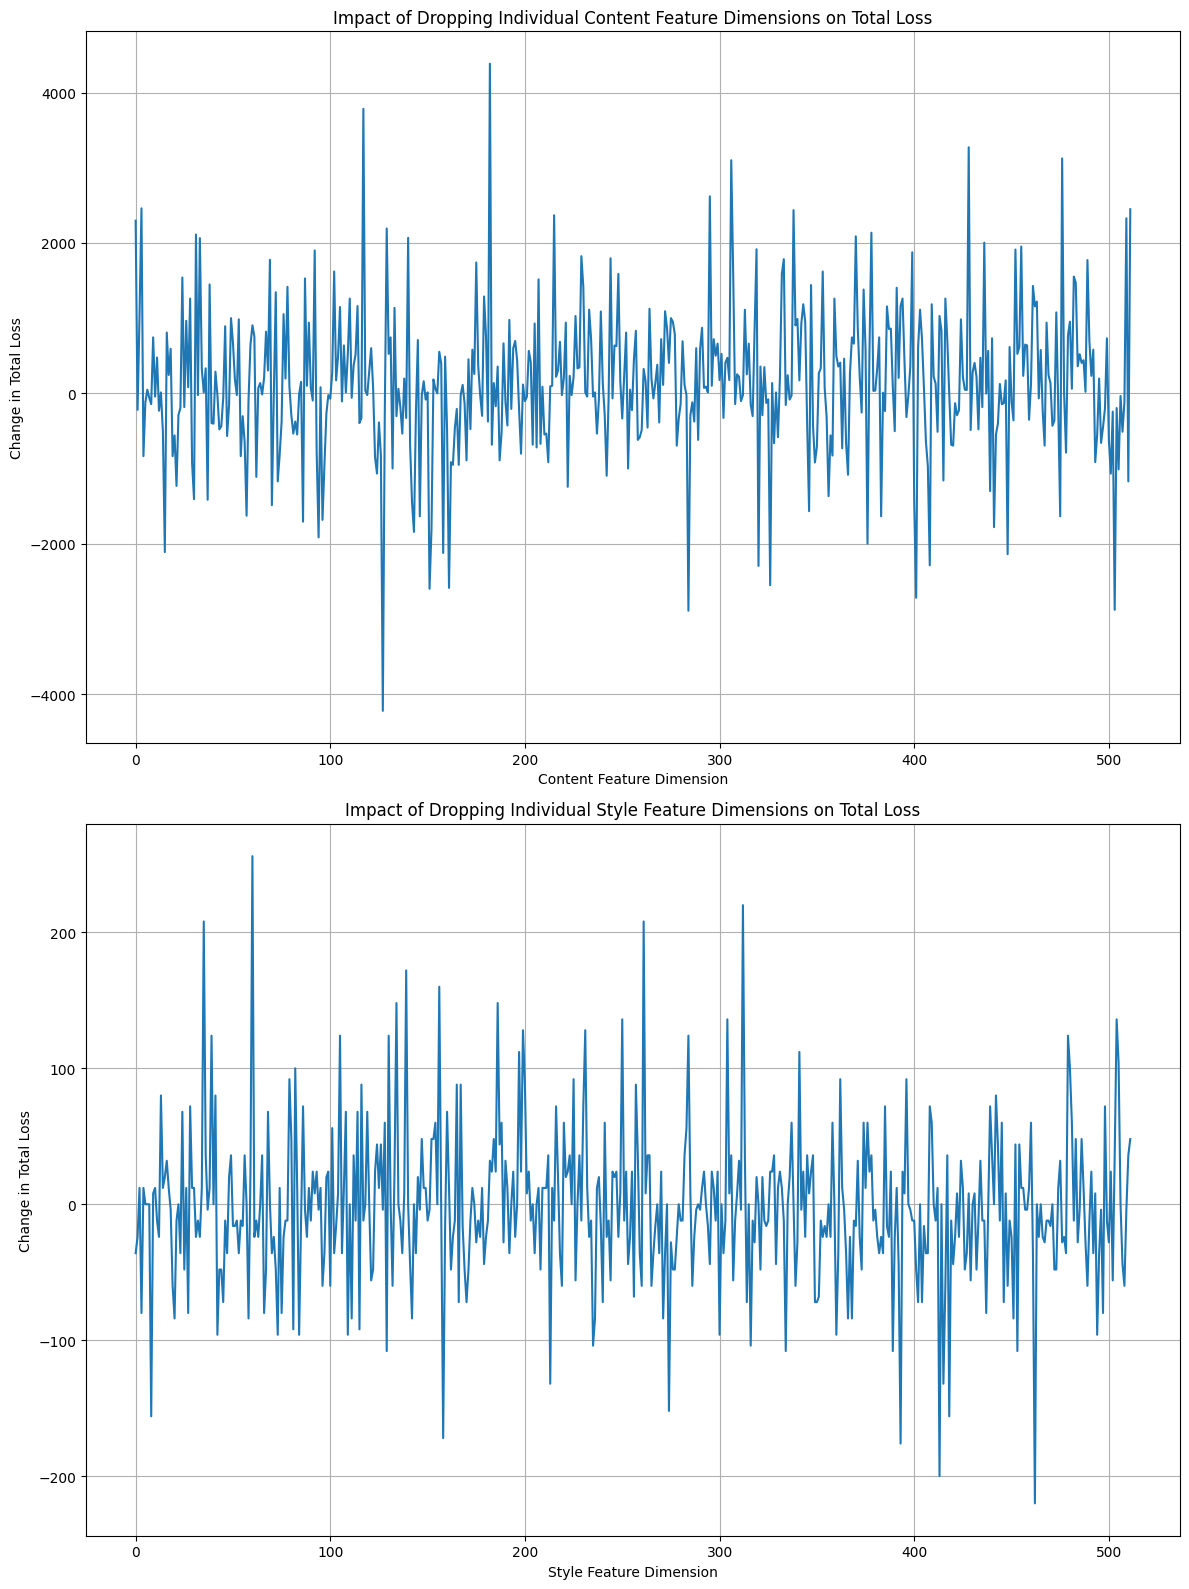

In [6]:
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load models
    vgg = encoder4()
    dec = decoder4()
    matrix = MulLayer('r41')
    
    vgg_dir = 'models/vgg_r41.pth'
    decoder_dir = "models/dec_r41.pth"
    
    vgg.load_state_dict(torch.load(vgg_dir))
    dec.load_state_dict(torch.load(decoder_dir))
    
    style_layers = ['r41']
    content_layers = ['r41']
    style_weight = 1e5
    content_weight = 1.0
    
    class Options:
        def __init__(self):
            self.contentPath = "data/content/"
            self.stylePath = "data/style/"
            self.loadSize = 256
            self.fineSize = 256

    opt = Options()
    
    loss_sensitivity = Loss_sensitivity(vgg, dec, matrix, style_layers, content_layers, style_weight, content_weight, device)
    
    # Load a single content and style image for the experiment
    content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
    style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)
    
    contentV, _ = content_dataset[0]
    styleV, _ = style_dataset[0]
    
    contentV = contentV.unsqueeze(0).to(device)
    styleV = styleV.unsqueeze(0).to(device)
    
    # Run dimension dropping experiment
    content_loss_impacts, style_loss_impacts = loss_sensitivity.run_dimension_dropping_experiment(contentV, styleV)
    
    # Plot the results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
    
    ax1.plot(range(len(content_loss_impacts)), content_loss_impacts)
    ax1.set_xlabel('Content Feature Dimension')
    ax1.set_ylabel('Change in Total Loss')
    ax1.set_title('Impact of Dropping Individual Content Feature Dimensions on Total Loss')
    ax1.grid(True)
    
    ax2.plot(range(len(style_loss_impacts)), style_loss_impacts)
    ax2.set_xlabel('Style Feature Dimension')
    ax2.set_ylabel('Change in Total Loss')
    ax2.set_title('Impact of Dropping Individual Style Feature Dimensions on Total Loss')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('dimension_dropping_plot.png')
    plt.show()

if __name__ == "__main__":
    main()



In [ ]:


def main():
    # ... (previous setup code remains unchanged) ...
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load models
    vgg = encoder4()
    dec = decoder4()
    matrix = MulLayer('r41')
    
    vgg_dir = 'models/vgg_r41.pth'
    decoder_dir = "models/dec_r41.pth"
    
    vgg.load_state_dict(torch.load(vgg_dir))
    dec.load_state_dict(torch.load(decoder_dir))
    
    style_layers = ['r41']
    content_layers = ['r41']
    style_weight = 1e5
    content_weight = 1.0
    
    class Options:
        def __init__(self):
            self.contentPath = "data/content/"
            self.stylePath = "data/style/"
            self.loadSize = 256
            self.fineSize = 256

    opt = Options()
    loss_sensitivity = Loss_sensitivity(vgg, dec, matrix, style_layers, content_layers, style_weight, content_weight, device)
    
    # Load a single content and style image for the experiment
    content_dataset = Dataset(opt.contentPath, opt.loadSize, opt.fineSize)
    style_dataset = Dataset(opt.stylePath, opt.loadSize, opt.fineSize)
    
    contentV, _ = content_dataset[0]
    styleV, _ = style_dataset[0]
    
    contentV = contentV.unsqueeze(0).to(device)
    styleV = styleV.unsqueeze(0).to(device)
    
    # Run dimension dropping experiment
    content_loss_impacts, style_loss_impacts = loss_sensitivity.run_dimension_dropping_experiment(contentV, styleV)
    
    # Run PCA experiment
    n_components = 50
    content_pca_loss_impacts, style_pca_loss_impacts, content_pca, style_pca = loss_sensitivity.run_pca_experiment(contentV, styleV, n_components)
    
    # Plot the results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 20))
    
    ax1.plot(range(len(content_loss_impacts)), content_loss_impacts)
    ax1.set_xlabel('Content Feature Dimension')
    ax1.set_ylabel('Change in Total Loss')
    ax1.set_title('Impact of Dropping Individual Content Feature Dimensions')
    ax1.grid(True)
    
    ax2.plot(range(len(style_loss_impacts)), style_loss_impacts)
    ax2.set_xlabel('Style Feature Dimension')
    ax2.set_ylabel('Change in Total Loss')
    ax2.set_title('Impact of Dropping Individual Style Feature Dimensions')
    ax2.grid(True)
    
    ax3.plot(range(n_components), content_pca_loss_impacts)
    ax3.set_xlabel('Content PCA Component')
    ax3.set_ylabel('Change in Total Loss')
    ax3.set_title('Impact of Dropping Content PCA Components')
    ax3.grid(True)
    
    ax4.plot(range(n_components), style_pca_loss_impacts)
    ax4.set_xlabel('Style PCA Component')
    ax4.set_ylabel('Change in Total Loss')
    ax4.set_title('Impact of Dropping Style PCA Components')
    ax4.grid(True)
    
    plt.tight_layout()
    plt.savefig('dimension_and_pca_analysis_plot.png')
    plt.show()
    
    # Plot explained variance ratio
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    ax1.plot(range(1, n_components + 1), content_pca.explained_variance_ratio_)
    ax1.set_xlabel('Number of Components')
    ax1.set_ylabel('Explained Variance Ratio')
    ax1.set_title('Explained Variance Ratio of Content PCA Components')
    ax1.grid(True)
    
    ax2.plot(range(1, n_components + 1), style_pca.explained_variance_ratio_)
    ax2.set_xlabel('Number of Components')
    ax2.set_ylabel('Explained Variance Ratio')
    ax2.set_title('Explained Variance Ratio of Style PCA Components')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('pca_explained_variance_plot.png')
    plt.show()


if __name__ == "__main__":
    main()